<a href="https://colab.research.google.com/github/WebberMark02/machine-learning-project/blob/main/project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Progetto di "Introduzione all'apprendimento automatico" di febbraio 2025
Daniele Russo  
Matricola: 0001028215  
Data: 11 febbraio 2025

---



## Introduzione
Questo notebook contiene tutti gli output di tutte le celle di codice Python, come richiesto nella traccia presente sulla piattaforma "Unibo Virtuale".  
  
Però, se dovesse essere necessario eseguire nuovamente l'intero notebook, ho incluso un link che consente di scaricare un file dei pesi del modello addestrato, così che il notebook possa caricarli e saltare la fase di preparazione dei dataset e la fase di addestramento della rete neurale, che è molto lunga e onerosa.  
  
Semplicemente per scopi illustrativi, specifico che questo notebook è stato eseguito utilizzando la GPU "T4" con l'opzione "High-RAM" offerta da Google Colab Pro.  
Caricando i pesi della rete neurale, è possibile eseguire questo notebook anche usando solamente la CPU offerta da Google Colab gratuitamente.

## File dei pesi della rete
[Ecco il file dei pesi del modello addestrato](https://drive.google.com/file/d/12ulAsUOJ4BMpi7akodTwWEzl59Z8Bgd2/view?usp=sharing)  
Da usare se si ritiene necessario eseguire nuovamente il notebook.  
  
Il file va inserito nella directory dell'ambiente di esecuzione di Google Colab.  
Prima di tutto, cliccare in alto a destra su "Connect" per connettersi a un ambiente di esecuzione offerto da Google Colab.  
Successivamente, cliccare nella barra a sinistra su "Files" e nell'interfaccia intitolata "Files" cliccare su "Upload to session storage" per caricare il file dei pesi scaricato.

## Preparazione iniziale
Importo le librerie necessarie e scelgo "tensorflow" come back-end per "Keras".

In [1]:
import numpy as np
import os
os.environ["KERAS_BACKEND"] = "tensorflow"
import keras
from matplotlib import pyplot as plt
import sklearn
import tensorflow as tf
from tensorflow.keras.datasets import mnist, fashion_mnist

Imposto le variabili globali.

In [2]:
seed = 42
training_set_size = 500000
testing_set_size = 5000
validation_set_size = 20000
image_shape = (32, 32, 1)
batch_size = 256
epochs = 100
learning_rate = 0.001

# Numero minimo di epoche da attendere prima di ridurre il learning rate.
reduce_lr_patience = 5

minimum_lr = 1e-6
training_backup_path = './daniele-russo-0001028215-ml-february-2025-trainingbackup/'
net_parameters_path = './daniele-russo-0001028215-ml-february-2025-network.weights.h5'

skipDatasetLoading = os.path.isfile(net_parameters_path)

Imposto il seed per la riproducibilità.
Ciò mi ha permesso di confrontare le prestazioni ottenute da diversi addestramenti per scegliere dei buoni valori da assegnare agli iper-parametri.

In [3]:
# Ciò imposta:
# 1) il seed di `numpy`
# 2) il seed per il generatore di numeri pseudo-casuali del backend (in questo caso, `tensorflow`)
# 3) il seed per i generatori di numeri pseudo-casuali di `python`
keras.utils.set_random_seed(seed)

Definisco il generatore di immagini sulle quali il modello
verrà addestrato e testato.  
Il generatore restituisce "batchsize" immagini; ogni immagine è
la media di due immagini scelte casualmente rispettivamente da 'x1' e 'x2'.  
Il generatore restituisce, inoltre, per ogni media di immagini, la coppia delle immagini delle quali è stata calcolata la media stessa.

In [4]:
def datagenerator(x1, x2, batchsize):
    n1 = x1.shape[0]
    n2 = x2.shape[0]
    while True:
        num1 = np.random.randint(0, n1, batchsize)
        num2 = np.random.randint(0, n2, batchsize)

        x_data = (x1[num1] + x2[num2]) / 2.0
        y_data = (x1[num1], x2[num2])

        yield x_data, y_data

Definisco una funzione per il controllo del bilanciamento delle classi.  
Mi servirà per verificare che la divisione stratificata abbia avuto successo.

In [5]:
def stampa_percentuale(y, title = ""):
  if title:
    print(title)
  # Calcolo le occorrenze di ciascuna classe nel dataset.
  unique, counts = np.unique(y, return_counts = True)
  # Calcolo la % di occorrenze per ciascuna classe.
  percentuali = (counts / len(y)) * 100
  # Stampo le occorrenze e le percentuali.
  for classe, conteggio, percentuale in zip(unique, counts, percentuali):
      print(f"Classe {classe}: Occorrenze = {conteggio}, Percentuale {percentuale} %" )
  print(f"Totale occorrenze : {sum(counts)}")
  print()

Definisco un modello banale.
Mi servirà per valutare che la rete abbia prestazioni migliori di esso.

In [6]:
def ide_model(x):
   return((x,x))

## Caricamento e preparazione dei dataset
Ora ha inizio la fase di caricamento e preparazione dei dataset che verranno utilizzati
per addestrare e esaminare le prestazioni della rete.

Prima di tutto, carico i training set e i testing set di "MNIST" e "Fashion MNIST".

In [7]:
(mnist_x_train, mnist_y_train), (mnist_x_test, mnist_y_test) = mnist.load_data()
(fashion_mnist_x_train, fashion_mnist_y_train), (fashion_mnist_x_test, fashion_mnist_y_test) = fashion_mnist.load_data()

print(np.shape(mnist_x_train))

11490434/11490434 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step
29515/29515 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
26421880/26421880 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step
5148/5148 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
4422102/4422102 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step
(60000, 28, 28)


Ridimensiono le immagini tramite padding, portando la loro risoluzione da 28x28 a 32x32.  
Inoltre, le normalizzo nell'intervallo [0, 1].

In [8]:
#normalize in and pad
mnist_x_train = np.pad(mnist_x_train,((0,0),(2,2),(2,2)))/255.
mnist_x_test = np.pad(mnist_x_test,((0,0),(2,2),(2,2)))/255.
fashion_mnist_x_train = np.pad(fashion_mnist_x_train,((0,0),(2,2),(2,2)))/255.
fashion_mnist_x_test = np.pad(fashion_mnist_x_test,((0,0),(2,2),(2,2)))/255.

print(np.shape(mnist_x_train))

(60000, 32, 32)


Aggiungo una dimensione agli array numpy delle immagini (non modifico affatto
le immagini).  
Mi serve per rendere le immagini compatibili con le dimensioni
del layer di input della rete neurale.

In [9]:
print(np.shape(mnist_x_train))
print(np.shape(mnist_x_test))
print(np.shape(fashion_mnist_x_train))
print(np.shape(fashion_mnist_x_test))

mnist_x_train = np.reshape(mnist_x_train, (mnist_x_train.shape[0], mnist_x_train.shape[1], mnist_x_train.shape[2], 1))
mnist_x_test = np.reshape(mnist_x_test, (mnist_x_test.shape[0], mnist_x_test.shape[1], mnist_x_test.shape[2], 1))
fashion_mnist_x_train = np.reshape(fashion_mnist_x_train, (fashion_mnist_x_train.shape[0], fashion_mnist_x_train.shape[1], fashion_mnist_x_train.shape[2], 1))
fashion_mnist_x_test = np.reshape(fashion_mnist_x_test, (fashion_mnist_x_test.shape[0], fashion_mnist_x_test.shape[1], fashion_mnist_x_test.shape[2], 1))

print(np.shape(mnist_x_train))
print(np.shape(mnist_x_test))
print(np.shape(fashion_mnist_x_train))
print(np.shape(fashion_mnist_x_test))

(60000, 32, 32)
(10000, 32, 32)
(60000, 32, 32)
(10000, 32, 32)
(60000, 32, 32, 1)
(10000, 32, 32, 1)
(60000, 32, 32, 1)
(10000, 32, 32, 1)


Visualizzo qualche immagine per accertarmi che l'operazione di reshaping non le abbia modificate.

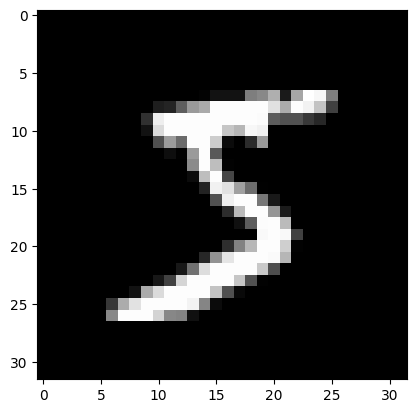

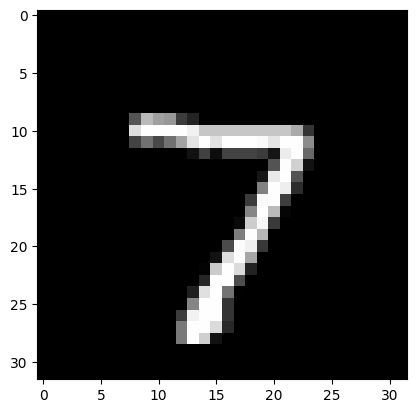

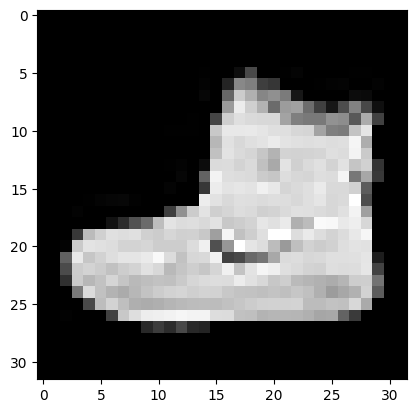

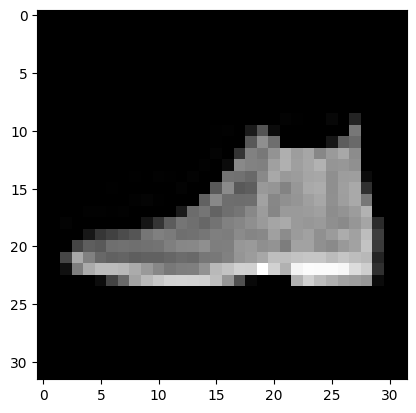

(32, 32, 1)


In [10]:
plt.imshow(mnist_x_train[0], cmap='gray')
plt.show()
plt.imshow(mnist_x_test[0], cmap='gray')
plt.show()
plt.imshow(fashion_mnist_x_train[0], cmap='gray')
plt.show()
plt.imshow(fashion_mnist_x_test[0], cmap='gray')
plt.show()

print(mnist_x_train[0].shape)

Controllo il bilanciamento delle classi nei training set prima della divisione stratificata.

In [11]:
stampa_percentuale(mnist_y_train, 'MNIST training set completo')
stampa_percentuale(fashion_mnist_y_train, 'Fashion MNIST training set completo')

MNIST training set completo
Classe 0: Occorrenze = 5923, Percentuale 9.871666666666666 %
Classe 1: Occorrenze = 6742, Percentuale 11.236666666666666 %
Classe 2: Occorrenze = 5958, Percentuale 9.93 %
Classe 3: Occorrenze = 6131, Percentuale 10.218333333333334 %
Classe 4: Occorrenze = 5842, Percentuale 9.736666666666666 %
Classe 5: Occorrenze = 5421, Percentuale 9.035 %
Classe 6: Occorrenze = 5918, Percentuale 9.863333333333333 %
Classe 7: Occorrenze = 6265, Percentuale 10.441666666666666 %
Classe 8: Occorrenze = 5851, Percentuale 9.751666666666667 %
Classe 9: Occorrenze = 5949, Percentuale 9.915000000000001 %
Totale occorrenze : 60000

Fashion MNIST training set completo
Classe 0: Occorrenze = 6000, Percentuale 10.0 %
Classe 1: Occorrenze = 6000, Percentuale 10.0 %
Classe 2: Occorrenze = 6000, Percentuale 10.0 %
Classe 3: Occorrenze = 6000, Percentuale 10.0 %
Classe 4: Occorrenze = 6000, Percentuale 10.0 %
Classe 5: Occorrenze = 6000, Percentuale 10.0 %
Classe 6: Occorrenze = 6000, Perc

Divido ogni training set in due insiemi: il training set e il validation set.
Le immagini dei validation set verranno usate per l'ottimizzazione degli iper-parametri della rete.
Ogni validation set conterrà il 30% delle immagini del training set di partenza.
Uso la stratificazione per mantenere le classi nelle stesse proporzioni.

In [12]:
mnist_x_train, mnist_x_val, mnist_y_train, mnist_y_val = sklearn.model_selection.train_test_split(mnist_x_train, mnist_y_train, test_size=0.3, stratify=mnist_y_train, random_state=seed)
fashion_mnist_x_train, fashion_mnist_x_val, fashion_mnist_y_train, fashion_mnist_y_val = sklearn.model_selection.train_test_split(fashion_mnist_x_train, fashion_mnist_y_train, test_size=0.3, stratify=fashion_mnist_y_train, random_state=seed)

Controllo il bilanciamento delle classi nei training set e nei validation set ottenuti dalla divisione stratificata.

In [13]:
stampa_percentuale(mnist_y_train, 'MNIST training set risultante')
stampa_percentuale(mnist_y_val, 'MNIST validation set risultante')

stampa_percentuale(fashion_mnist_y_train, 'Fashion MNIST training set risultante')
stampa_percentuale(fashion_mnist_y_val, 'Fashion MNIST validation set risultante')

MNIST training set risultante
Classe 0: Occorrenze = 4146, Percentuale 9.871428571428572 %
Classe 1: Occorrenze = 4719, Percentuale 11.235714285714286 %
Classe 2: Occorrenze = 4171, Percentuale 9.93095238095238 %
Classe 3: Occorrenze = 4292, Percentuale 10.21904761904762 %
Classe 4: Occorrenze = 4089, Percentuale 9.735714285714286 %
Classe 5: Occorrenze = 3795, Percentuale 9.035714285714286 %
Classe 6: Occorrenze = 4143, Percentuale 9.864285714285714 %
Classe 7: Occorrenze = 4385, Percentuale 10.44047619047619 %
Classe 8: Occorrenze = 4096, Percentuale 9.752380952380953 %
Classe 9: Occorrenze = 4164, Percentuale 9.914285714285715 %
Totale occorrenze : 42000

MNIST validation set risultante
Classe 0: Occorrenze = 1777, Percentuale 9.872222222222222 %
Classe 1: Occorrenze = 2023, Percentuale 11.238888888888889 %
Classe 2: Occorrenze = 1787, Percentuale 9.927777777777779 %
Classe 3: Occorrenze = 1839, Percentuale 10.216666666666667 %
Classe 4: Occorrenze = 1753, Percentuale 9.738888888888

Creo tre istanze del generatore per generare il training set, il validation set e il testing set finali.

In [14]:
traingen = datagenerator(mnist_x_train, fashion_mnist_x_train, training_set_size)
valgen = datagenerator(mnist_x_val, fashion_mnist_x_val, validation_set_size)
testgen = datagenerator(mnist_x_test, fashion_mnist_x_test, testing_set_size)

Creo il training set e il validation set.

In [15]:
if not skipDatasetLoading:
  x_train, y_train = next(traingen)
  x_val, y_val = next(valgen)

Verifico che le dimensioni dei due dataset siano corrette.

In [16]:
if not skipDatasetLoading:
  print(x_train.shape)
  print(x_val.shape)

  print(len(y_train))
  print(len(y_val))

  print(y_train[0].shape)
  print(y_train[1].shape)
  print(y_val[0].shape)
  print(y_val[1].shape)

(500000, 32, 32, 1)
(20000, 32, 32, 1)
2
2
(500000, 32, 32, 1)
(500000, 32, 32, 1)
(20000, 32, 32, 1)
(20000, 32, 32, 1)


Controllo che i valori dei pixel delle immagini appartengano all'intervallo [0,1].

In [17]:
if not skipDatasetLoading:
  print(np.min(x_train[0]), np.max(x_train[0]))
  print(np.min(x_val[0]), np.max(x_val[0]))

0.0 0.9392156862745098
0.0 0.711764705882353


Mostro qualche immagine dei due dataset.

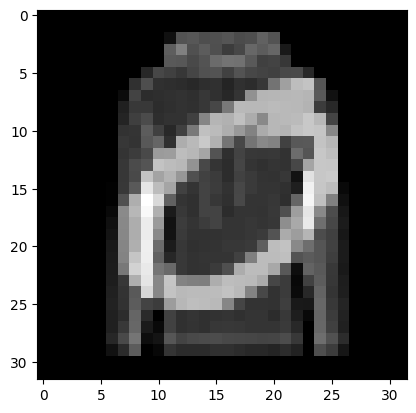

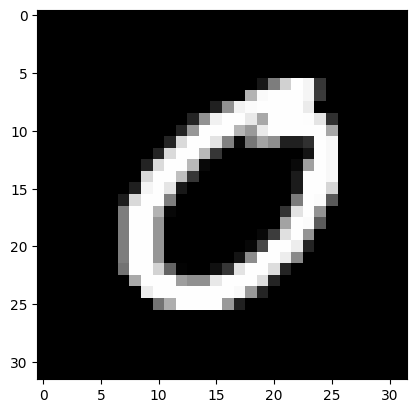

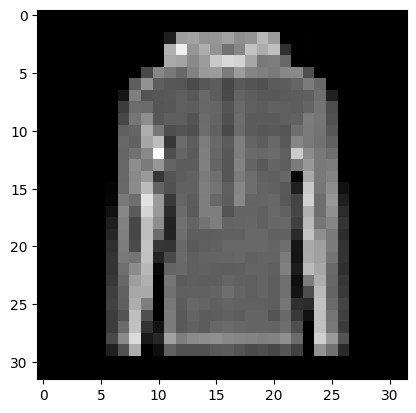

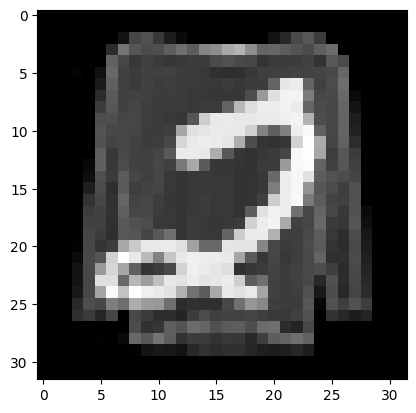

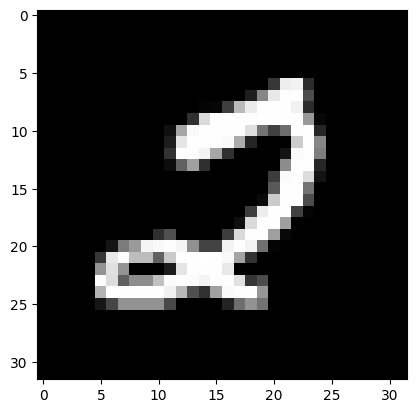

(32, 32, 1)


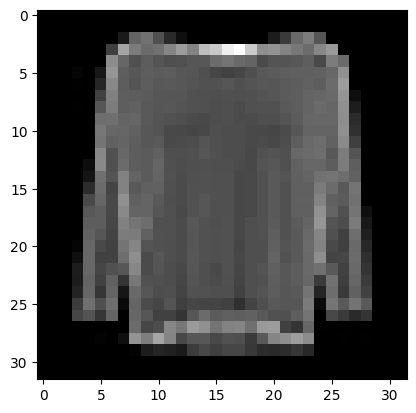

In [18]:
if not skipDatasetLoading:
  plt.imshow(x_train[0], cmap='gray')
  plt.show()
  plt.imshow(y_train[0][0], cmap='gray')
  plt.show()
  plt.imshow(y_train[1][0], cmap='gray')
  plt.show()
  plt.imshow(x_val[0], cmap='gray')
  plt.show()
  plt.imshow(y_val[0][0], cmap='gray')
  plt.show()
  plt.imshow(y_val[1][0], cmap='gray')

  print(x_train[0].shape)

## Definizione e compilazione della rete neurale
La fase di preparazione dei dataset è completa.
Ora viene definita e compilata la rete neurale.  
    
Essa è formata da un semplice autoencoder con due layer di output.
La rete restituisce le due immagini la cui media è l'immagine di partenza, ricostruendola il più fedelmente possibile.
  
Nei layer convoluzionali, ho impostato il parametro "padding" a "same" per garantire che le dimensioni dei due layer di output siano uguali a quelle del layer di input.

In [19]:
def build_neural_network():
  inputs = keras.Input(shape = image_shape, name = 'InputImage')

  # Encoder
  x = keras.layers.Conv2D(32, (3, 3), activation='relu', padding='same')(inputs)
  x = keras.layers.MaxPooling2D((2, 2), padding='same')(x)
  x = keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same')(x)
  encoded = keras.layers.MaxPooling2D((2, 2), padding='same')(x)

  # Decoder
  x = keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same')(encoded)
  x = keras.layers.UpSampling2D((2, 2))(x)
  x = keras.layers.Conv2D(32, (3, 3), activation='relu', padding='same')(x)
  x = keras.layers.UpSampling2D((2, 2))(x)

  decoded1 = keras.layers.Conv2D(1, (3, 3), activation='sigmoid', padding='same', name='MNIST_Image')(x)
  decoded2 = keras.layers.Conv2D(1, (3, 3), activation='sigmoid', padding='same', name='Fashion_MNIST_Image')(x)

  model = keras.Model(inputs=inputs, outputs=[decoded1, decoded2])

  return model

Istanzio la rete e mostro i suoi dettagli.

In [20]:
model = build_neural_network()
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ InputImage (InputLayer)   │ (None, 32, 32, 1)      │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d (Conv2D)           │ (None, 32, 32, 32)     │            320 │ InputImage[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d             │ (None, 16, 16, 32)     │              0 │ conv2d[0][0]           │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_1 (Conv2D)         │ (None, 16, 16, 64)     │         18,496 │ max_pooling2d[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_1           │ (None, 8, 8, 64)       │              0 │ conv2d_1[0][0]         │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_2 (Conv2D)         │ (None, 8, 8, 64)       │         36,928 │ max_pooling2d_1[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ up_sampling2d             │ (None, 16, 16, 64)     │              0 │ conv2d_2[0][0]         │
│ (UpSampling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_3 (Conv2D)         │ (None, 16, 16, 32)     │         18,464 │ up_sampling2d[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ up_sampling2d_1           │ (None, 32, 32, 32)     │              0 │ conv2d_3[0][0]         │
│ (UpSampling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ MNIST_Image (Conv2D)      │ (None, 32, 32, 1)      │            289 │ up_sampling2d_1[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ Fashion_MNIST_Image       │ (None, 32, 32, 1)      │            289 │ up_sampling2d_1[0][0]  │
│ (Conv2D)                  │                        │                │                        │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 74,786 (292.13 KB)

 Trainable params: 74,786 (292.13 KB)

 Non-trainable params: 0 (0.00 B)

Visualizzo un plot della rete.

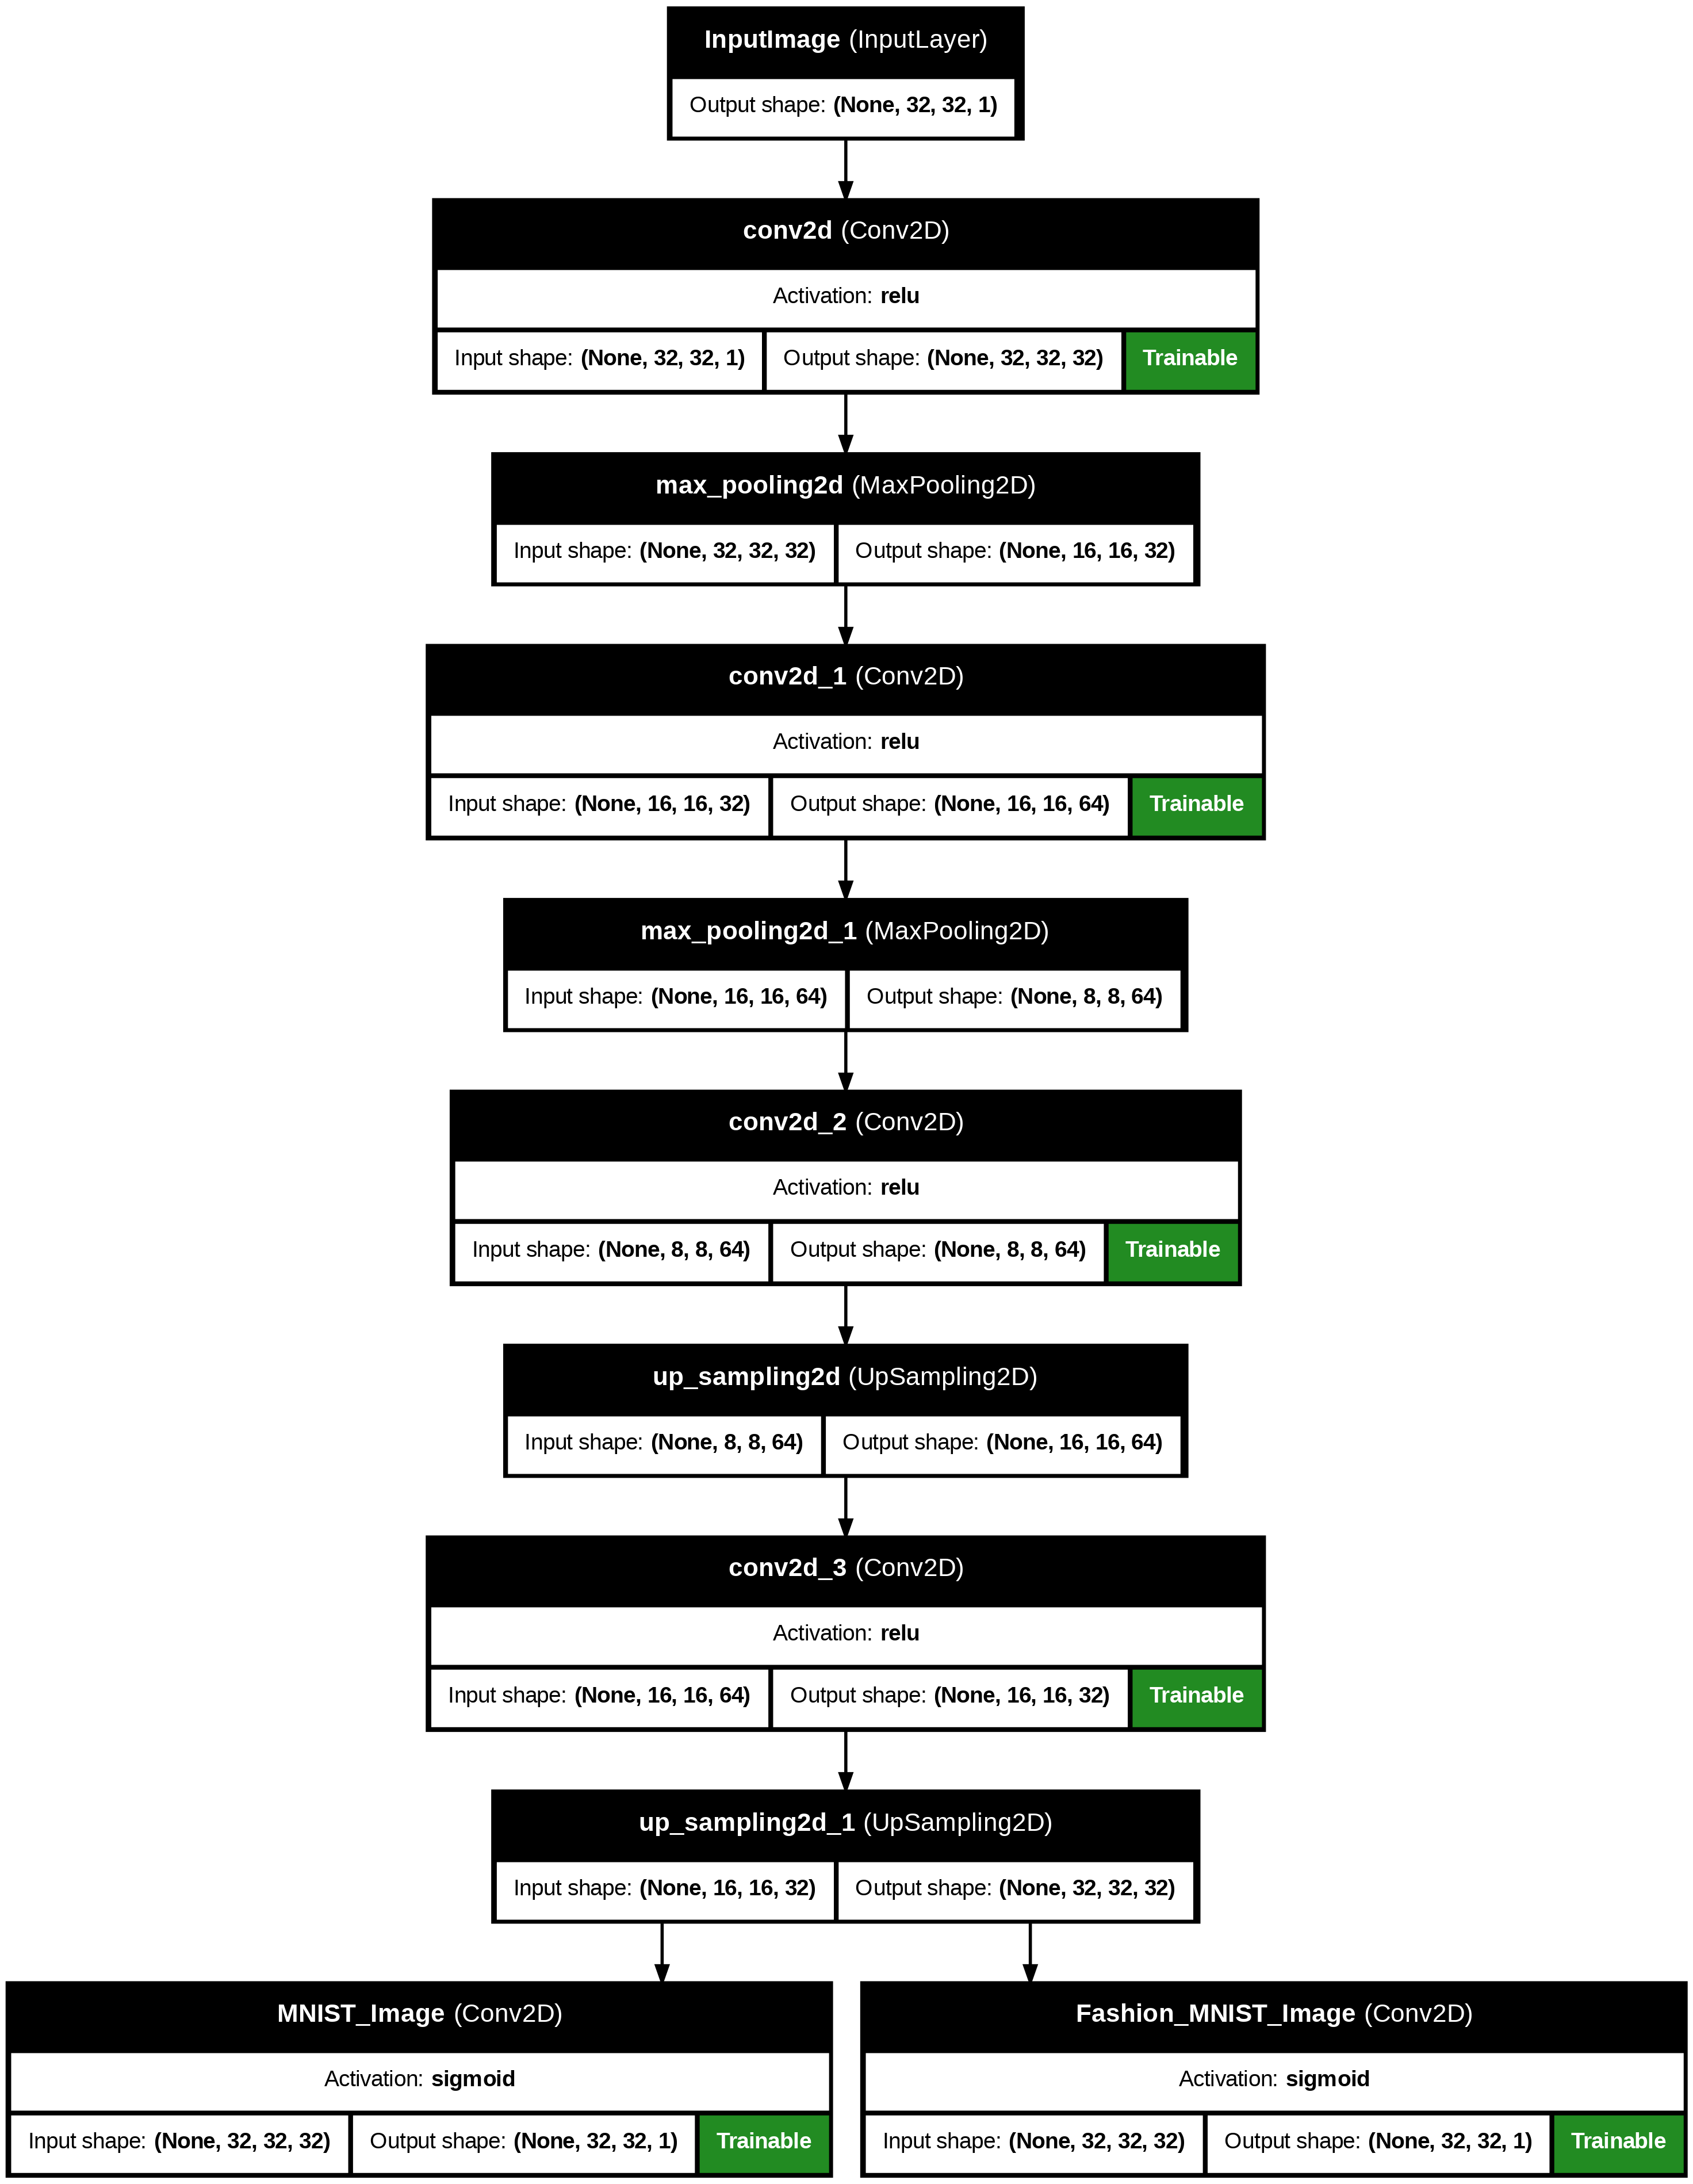

In [21]:
keras.utils.plot_model(model, "model.png", show_shapes = True, show_layer_names = True, show_layer_activations = True, show_trainable = True)

Definisco la funzione di costo che l'addestramento minimizzerà il più possibile.

In [22]:
mse_loss = keras.losses.MeanSquaredError(
    reduction = "sum_over_batch_size",
    name = "mean_squared_error"
)

Compilo la rete.

In [23]:
model.compile(
    loss = mse_loss,
    optimizer = keras.optimizers.AdamW(learning_rate = learning_rate),
)

Definisco una callback "BackupAndRestore".  
Alla fine di ogni epoca di addestramento, essa salva lo stato dell'addestramento in file di backup temporanei.  
Se il notebook dovesse bloccarsi a tempo di esecuzione, sarà possibile riavviare l'addestramento ripristinando l'ultimo stato salvato nei file di backup.

In [24]:
backup_and_restore = keras.callbacks.BackupAndRestore(backup_dir = training_backup_path)

Definisco una callback per il controllo del learning rate.

In [25]:
reduce_lr = keras.callbacks.ReduceLROnPlateau(
    monitor = 'val_loss',           # Verrà monitorato il costo sui dati di validazione.
    factor = 0.2,                   # Fattore di riduzione del learning rate.
    patience = reduce_lr_patience,  # Numero minimo di epoche da attendere prima di ridurre il learning rate.
    min_lr = minimum_lr             # Minimo valore che il learning rate potrà assumere durante l'addestramento.
)

## Addestramento della rete neurale
Se è disponibile un file di pesi del modello, carico i pesi e salto
l'addestramento.  
Altrimenti, addestro il modello e salvo i pesi risultanti.

In [26]:
try:
  print('Ricerca di un file dei pesi in corso...')
  model.load_weights(net_parameters_path)
  print('Pesi caricati')
except:
  print('Nessun file dei pesi trovato')
  history = model.fit(x_train, y_train, batch_size = batch_size, epochs = epochs, validation_data = (x_val, y_val), callbacks = [backup_and_restore, reduce_lr])
  print('Salvataggio dei pesi in corso...')
  model.save_weights(net_parameters_path)
  print('Pesi salvati')

Ricerca di un file dei pesi in corso...
Nessun file dei pesi trovato
Epoch 1/100
1954/1954 ━━━━━━━━━━━━━━━━━━━━ 36s 16ms/step - Fashion_MNIST_Image_loss: 0.0268 - MNIST_Image_loss: 0.0878 - loss: 0.1146 - val_Fashion_MNIST_Image_loss: 0.0113 - val_MNIST_Image_loss: 0.0113 - val_loss: 0.0226 - learning_rate: 0.0010
Epoch 2/100
1954/1954 ━━━━━━━━━━━━━━━━━━━━ 28s 14ms/step - Fashion_MNIST_Image_loss: 0.0098 - MNIST_Image_loss: 0.0088 - loss: 0.0186 - val_Fashion_MNIST_Image_loss: 0.0081 - val_MNIST_Image_loss: 0.0066 - val_loss: 0.0146 - learning_rate: 0.0010
Epoch 3/100
1954/1954 ━━━━━━━━━━━━━━━━━━━━ 28s 14ms/step - Fashion_MNIST_Image_loss: 0.0075 - MNIST_Image_loss: 0.0059 - loss: 0.0134 - val_Fashion_MNIST_Image_loss: 0.0068 - val_MNIST_Image_loss: 0.0053 - val_loss: 0.0120 - learning_rate: 0.0010
Epoch 4/100
1954/1954 ━━━━━━━━━━━━━━━━━━━━ 28s 14ms/step - Fashion_MNIST_Image_loss: 0.0066 - MNIST_Image_loss: 0.0050 - loss: 0.0116 - val_Fashion_MNIST_Image_loss: 0.0062 - val_MNIST_Image

## Visualizzazione dei risultati e test finali
Ora definisco una funzione per la creazione di grafici della storia dell'addestramento.  
Se non sono stati caricati dei pesi e, quindi, è stato eseguito l'addestramento, allora vengono mostrati quattro grafici.

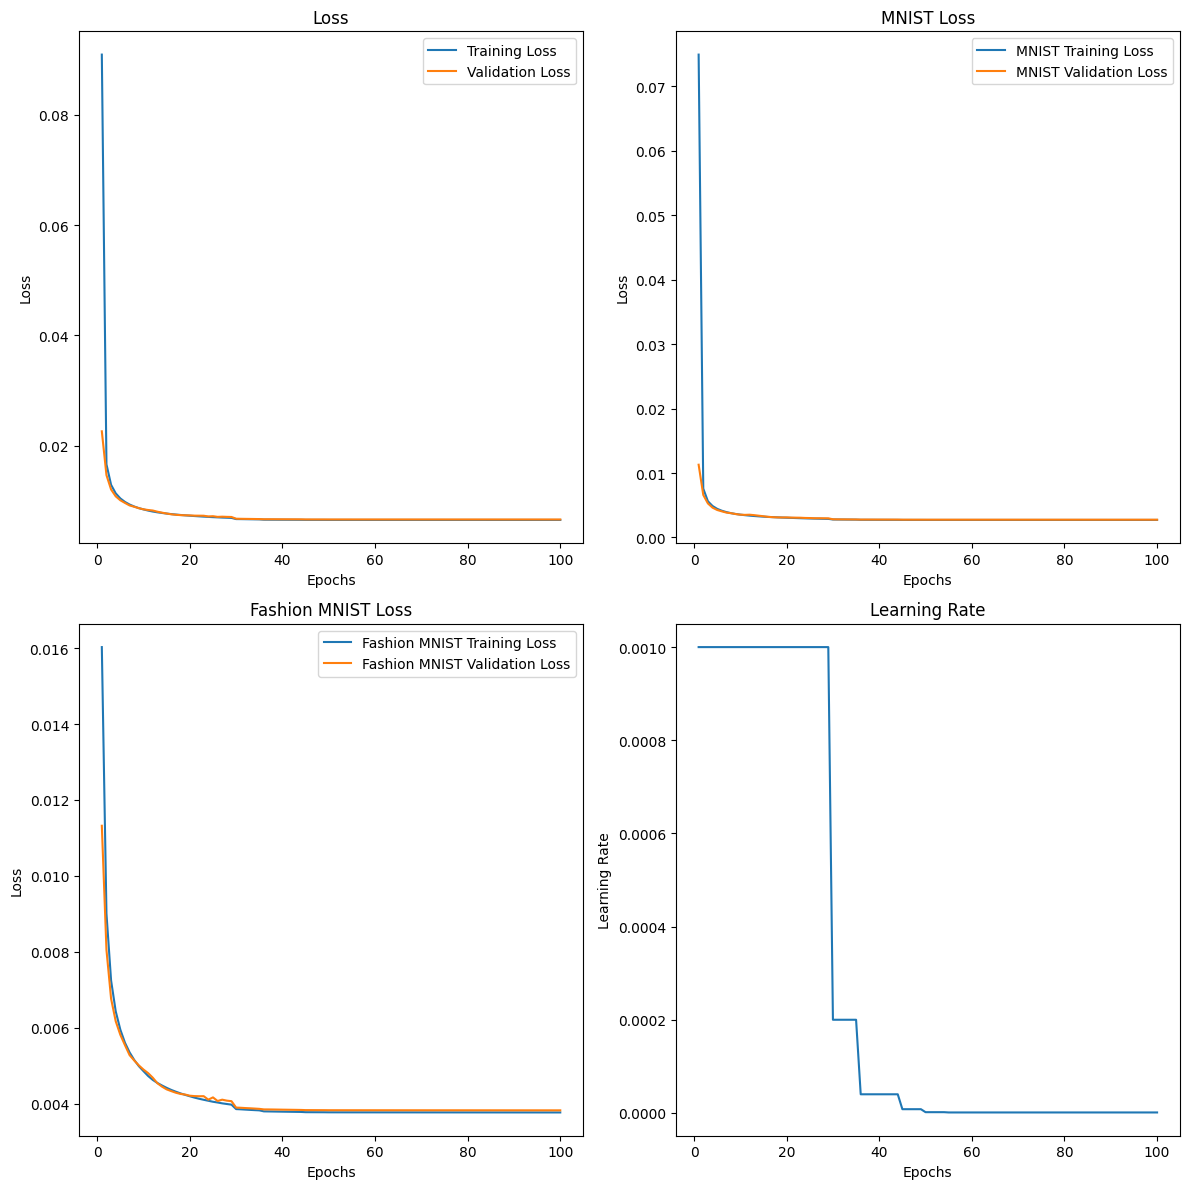

In [27]:
def plot_training_history(history):

    training_loss = history.history['loss']
    validation_loss = history.history['val_loss']
    mnist_training_loss = history.history['MNIST_Image_loss']
    mnist_validation_loss = history.history['val_MNIST_Image_loss']
    fashion_mnist_training_loss = history.history['Fashion_MNIST_Image_loss']
    fashion_mnist_validation_loss = history.history['val_Fashion_MNIST_Image_loss']
    learning_rate = history.history['learning_rate']

    # Crea un grafico
    epochs = range(1, len(training_loss) + 1)
    plt.figure(figsize=(12, 12))

    plt.subplot(2, 2, 1)
    plt.plot(epochs, training_loss, label='Training Loss')
    plt.plot(epochs, validation_loss, label='Validation Loss')
    plt.title('Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.subplot(2, 2, 2)
    plt.plot(epochs, mnist_training_loss, label='MNIST Training Loss')
    plt.plot(epochs, mnist_validation_loss, label='MNIST Validation Loss')
    plt.title('MNIST Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.subplot(2, 2, 3)
    plt.plot(epochs, fashion_mnist_training_loss, label='Fashion MNIST Training Loss')
    plt.plot(epochs, fashion_mnist_validation_loss, label='Fashion MNIST Validation Loss')
    plt.title('Fashion MNIST Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.subplot(2, 2, 4)
    plt.plot(epochs, learning_rate)
    plt.title('Learning Rate')
    plt.xlabel('Epochs')
    plt.ylabel('Learning Rate')

    plt.tight_layout()
    plt.show()

if not skipDatasetLoading:
  plot_training_history(history)

Definisco due funzioni per la valutazione finale del modello.

In [28]:
def eval_model(model):
  x, (y1, y2) = next(testgen)
  if isinstance(model, keras.Model):
    pred1, pred2 = model.predict(x)
  else:
    pred1, pred2 = model(x)

  return (np.mean((pred1-y1)**2) + np.mean((pred2-y2)**2)) / 2

def multiple_eval_model(model, repeat_eval = 10):
  eval_results = []
  for i in range(repeat_eval):
    eval_results.append(eval_model(model))
  print("mse mean = ", np.mean(eval_results))
  print("mse standard deviation = ", np.std(eval_results))

Valuto la rete e il modello casuale e confronto le loro prestazioni.  
Più questi valori sono vicini a zero, più la rete è accurata.

In [29]:
print('Valutazione modello banale')
multiple_eval_model(ide_model)

print('Valutazione rete neurale')
multiple_eval_model(model)

Valutazione modello banale
mse mean =  0.03632118649520316
mse standard deviation =  0.00019461979398327538
Valutazione rete neurale
157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
mse mean =  0.003267910893920746
mse standard deviation =  2.0065698171003766e-05


Mostro 30 esempi di previsioni del modello banale e della rete neurale.

Campione di esempio numero  1


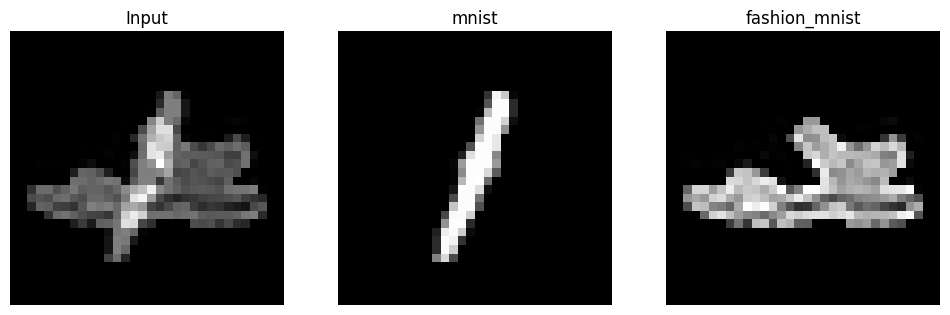

Previsione del modello banale


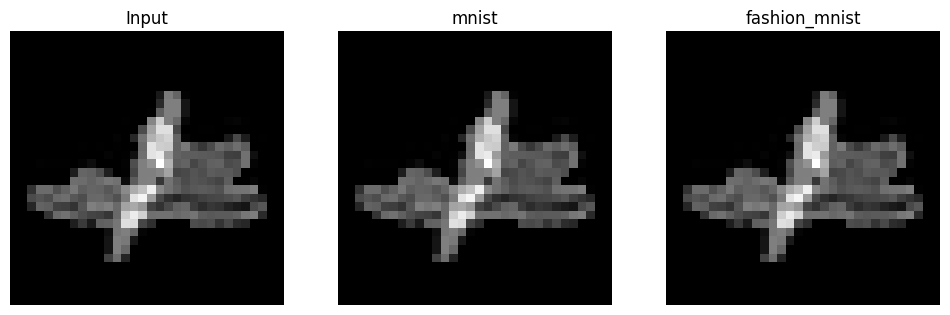

Previsione della rete neurale
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 397ms/step


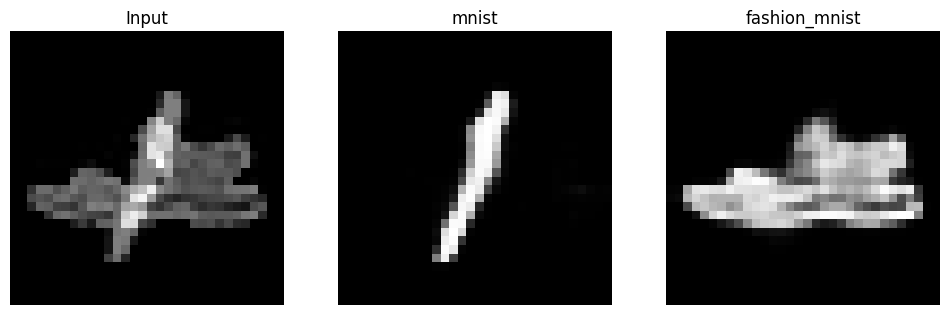



Campione di esempio numero  2


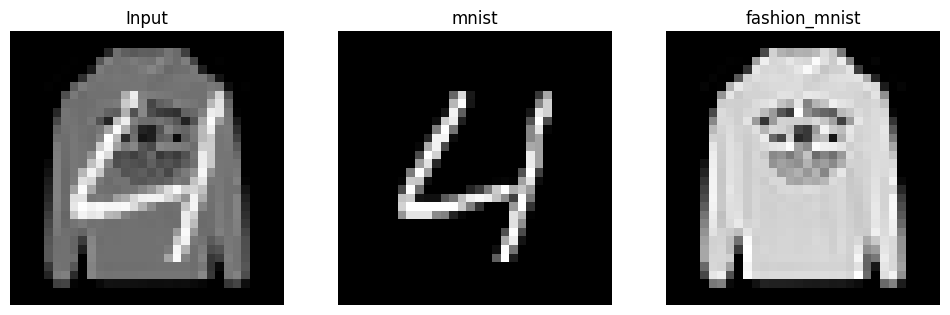

Previsione del modello banale


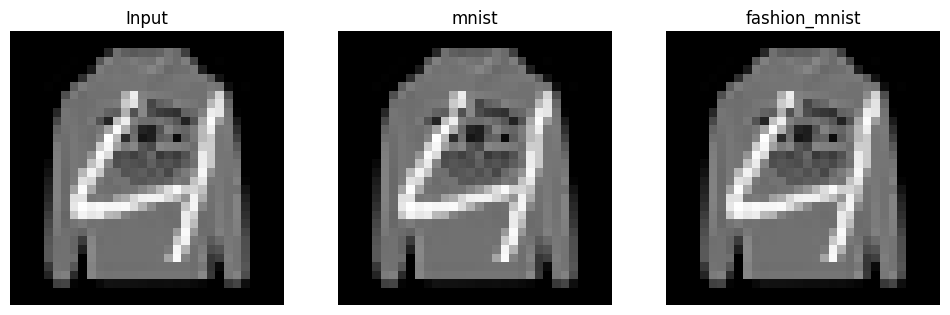

Previsione della rete neurale
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


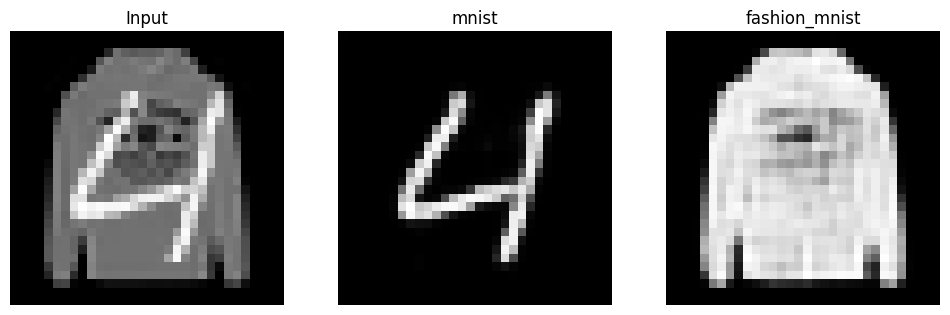



Campione di esempio numero  3


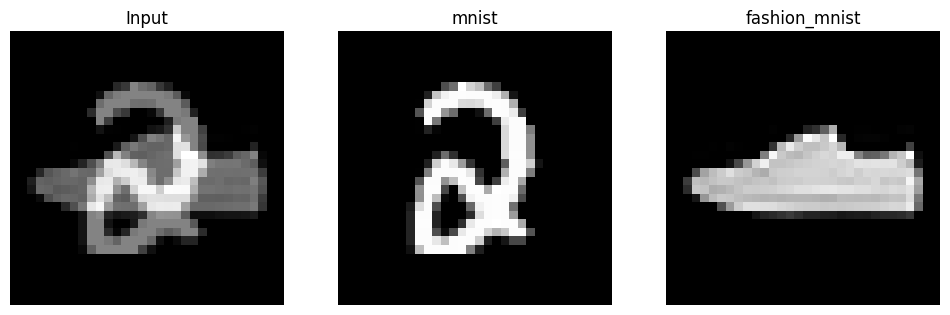

Previsione del modello banale


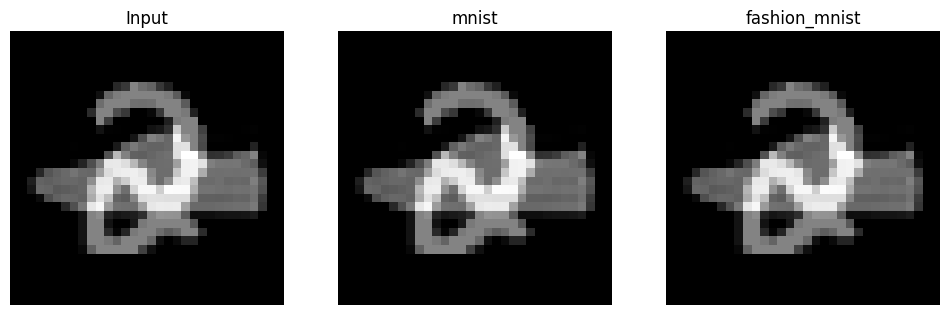

Previsione della rete neurale
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


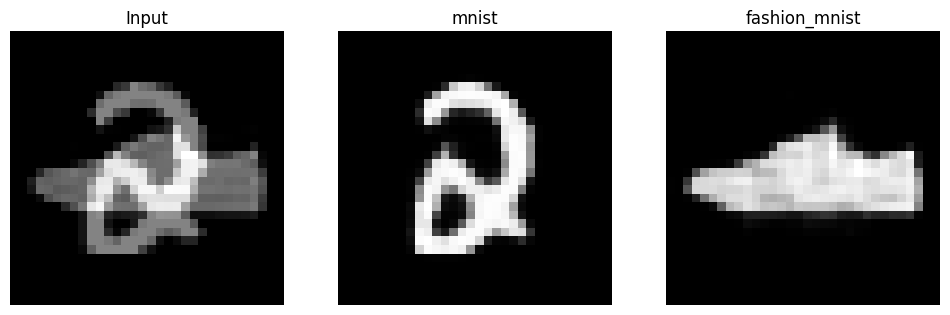



Campione di esempio numero  4


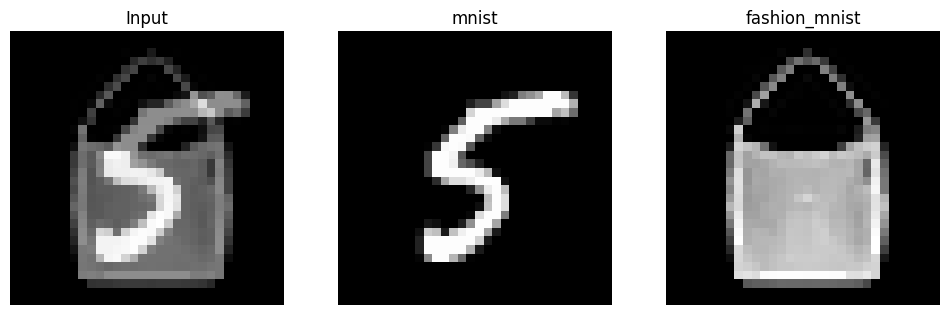

Previsione del modello banale


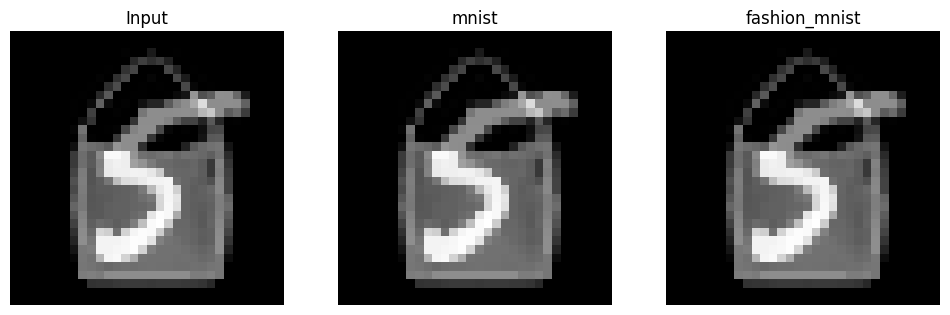

Previsione della rete neurale
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


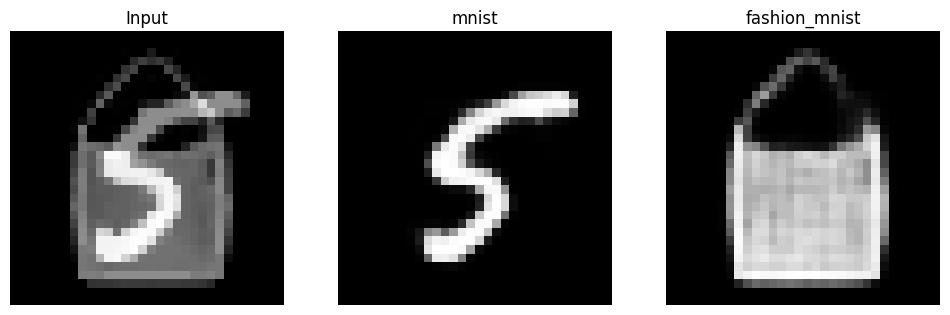



Campione di esempio numero  5


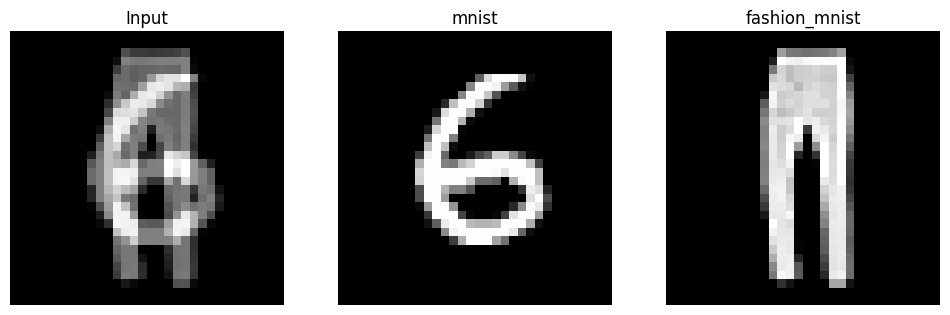

Previsione del modello banale


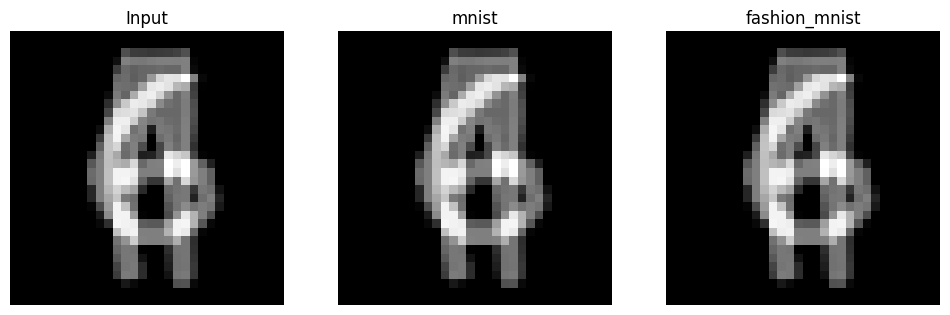

Previsione della rete neurale
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


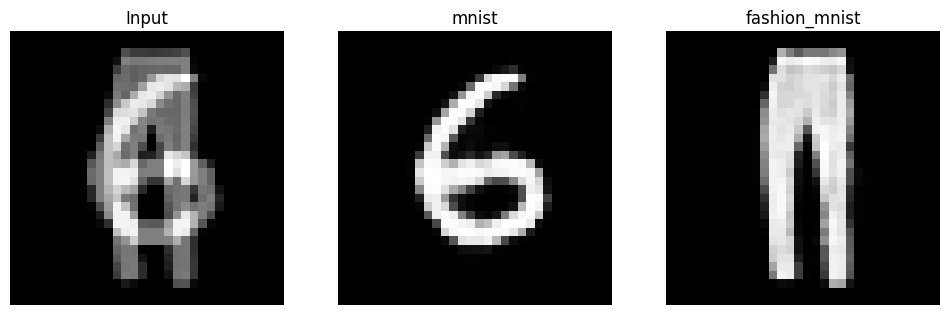



Campione di esempio numero  6


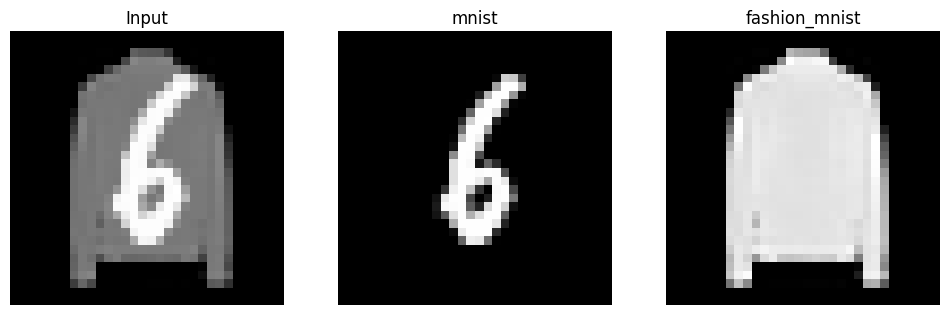

Previsione del modello banale


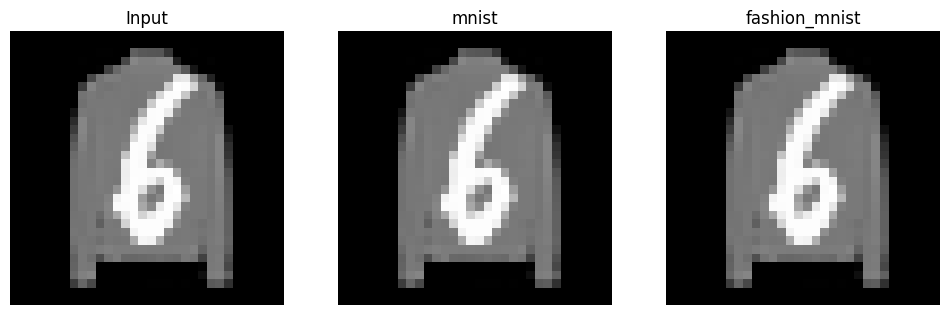

Previsione della rete neurale
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


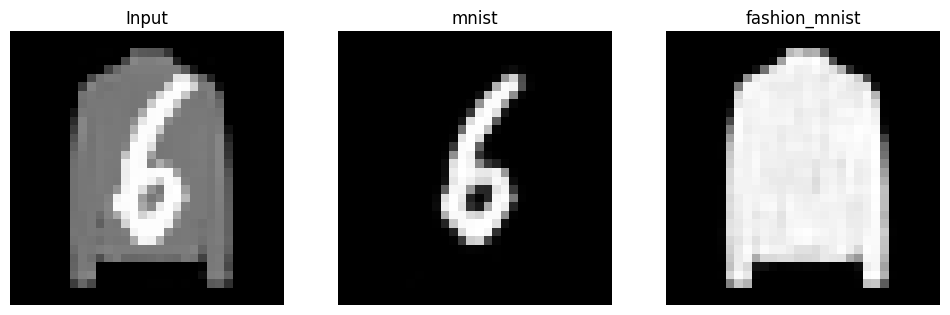



Campione di esempio numero  7


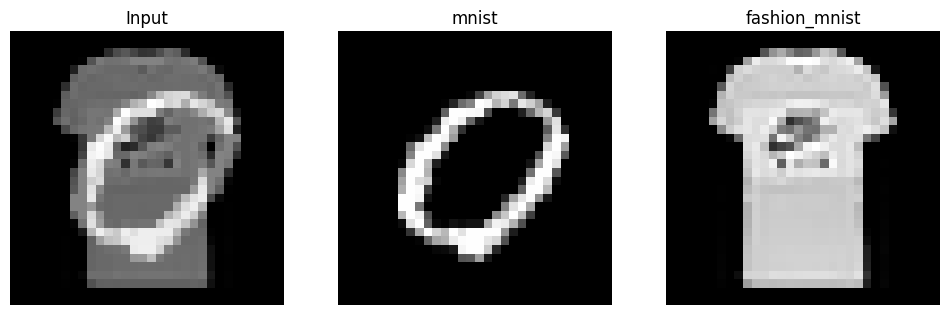

Previsione del modello banale


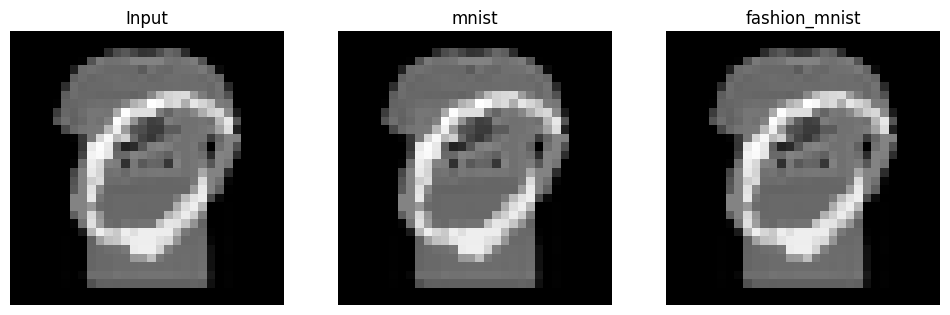

Previsione della rete neurale
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


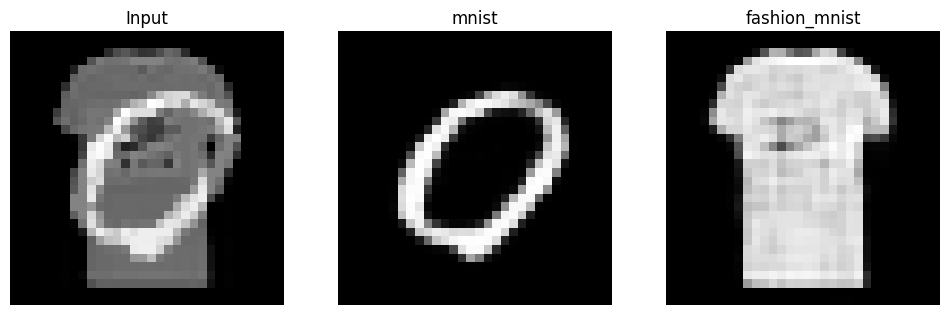



Campione di esempio numero  8


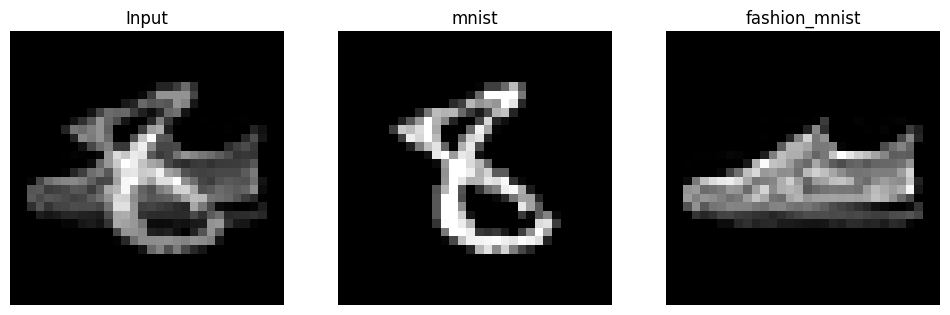

Previsione del modello banale


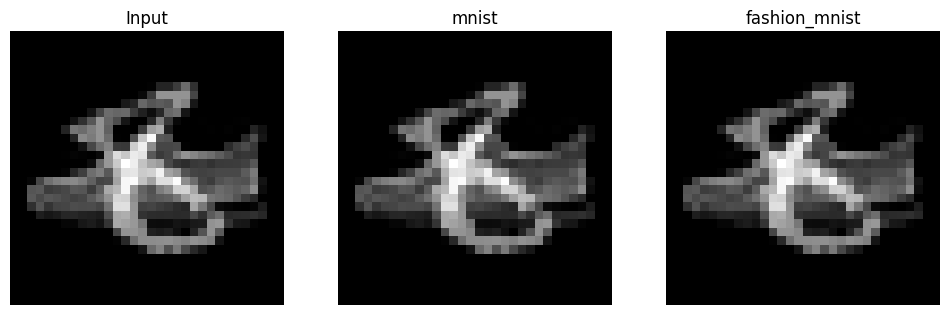

Previsione della rete neurale
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


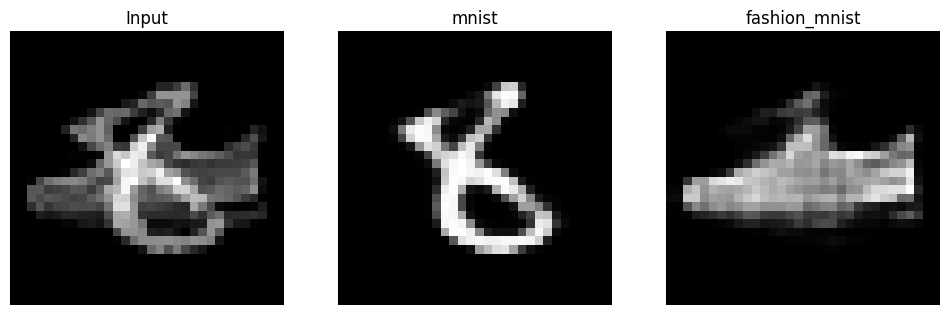



Campione di esempio numero  9


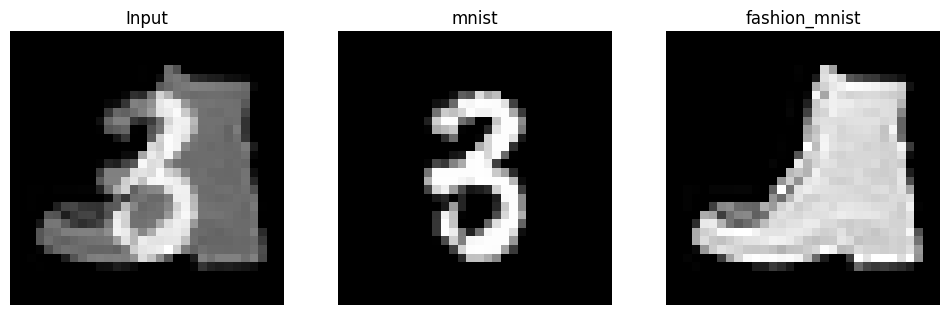

Previsione del modello banale


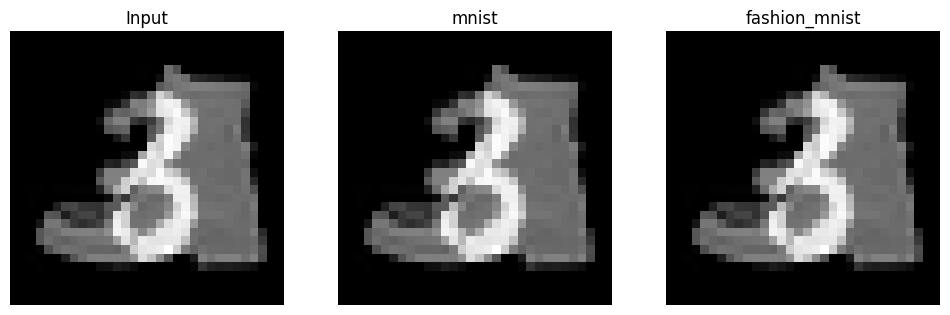

Previsione della rete neurale
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


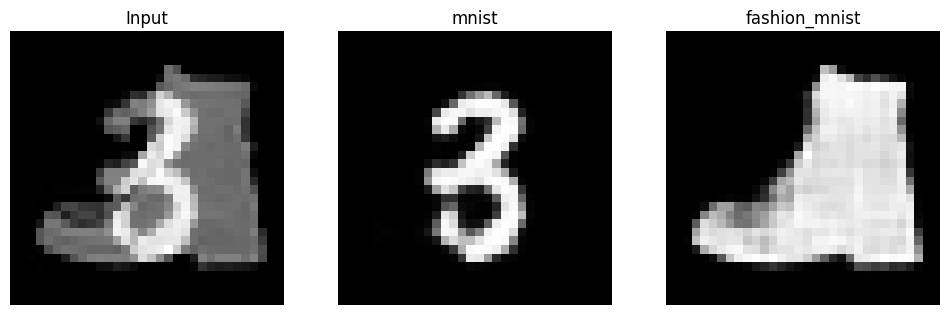



Campione di esempio numero  10


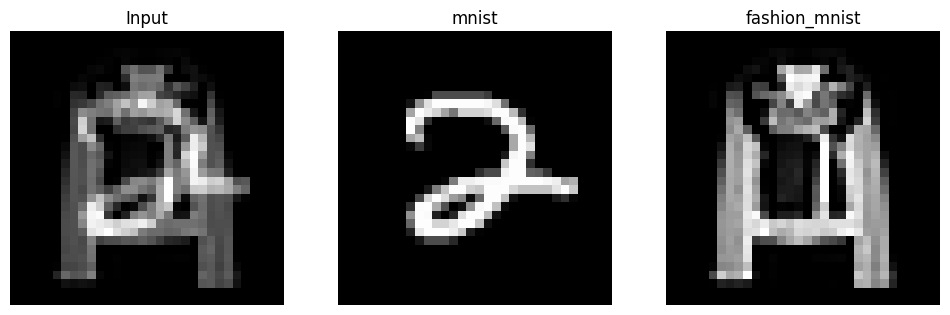

Previsione del modello banale


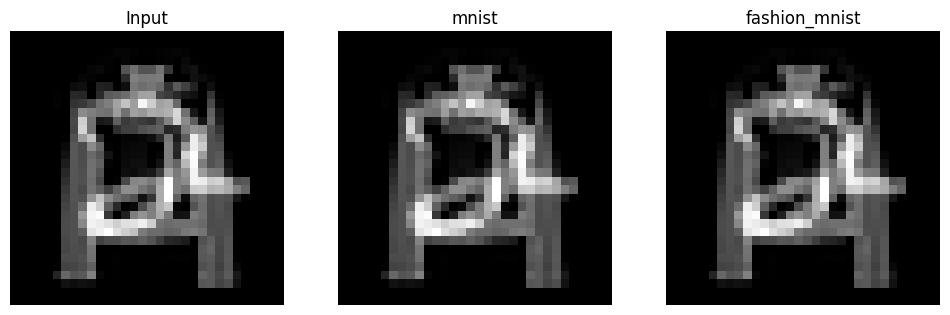

Previsione della rete neurale
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


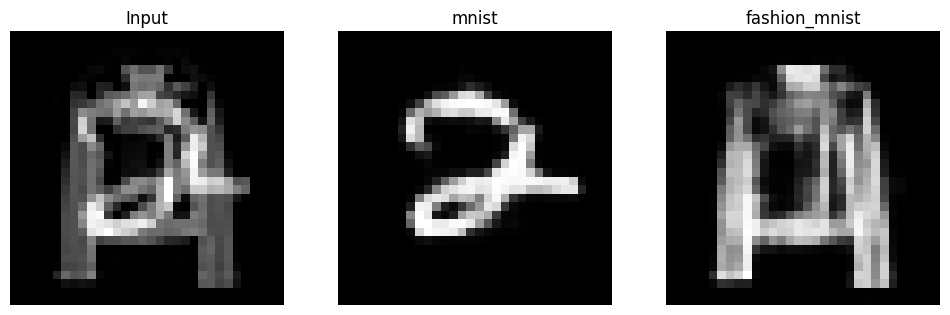



Campione di esempio numero  11


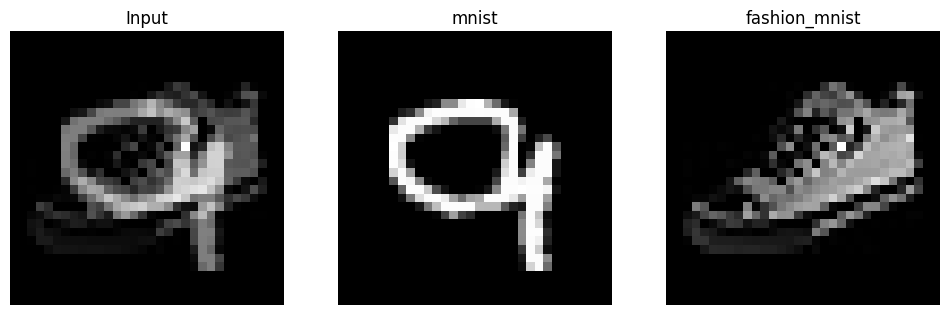

Previsione del modello banale


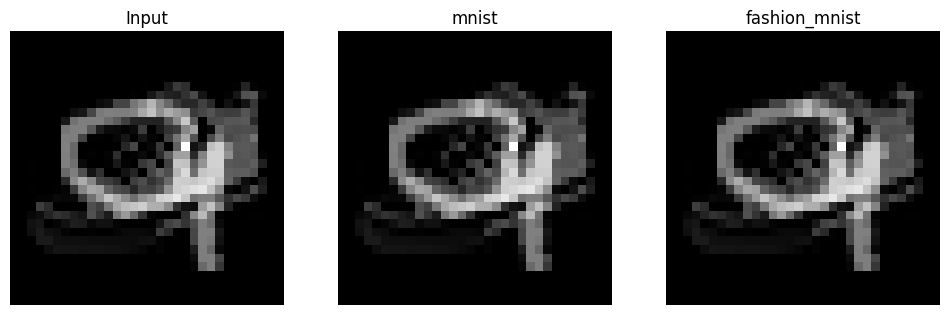

Previsione della rete neurale
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


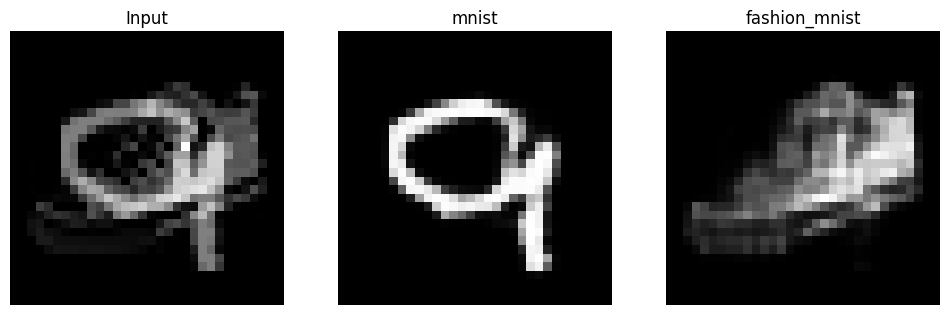



Campione di esempio numero  12


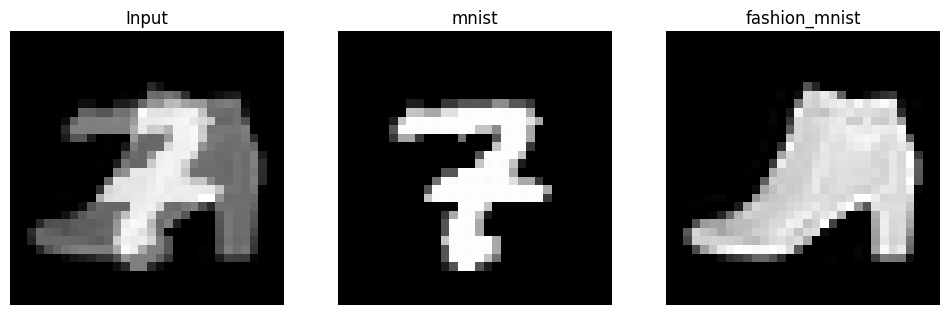

Previsione del modello banale


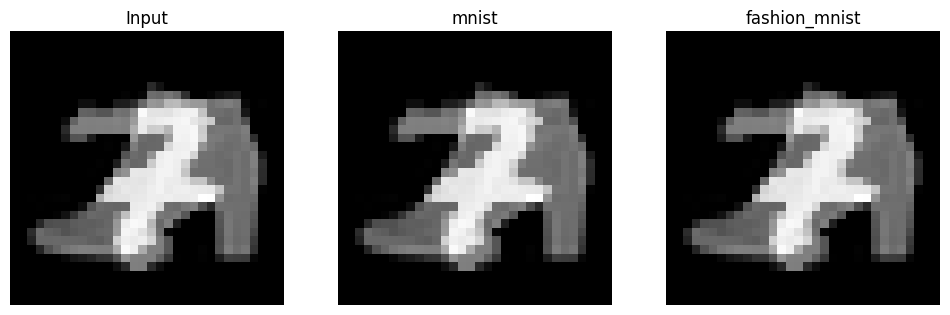

Previsione della rete neurale
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


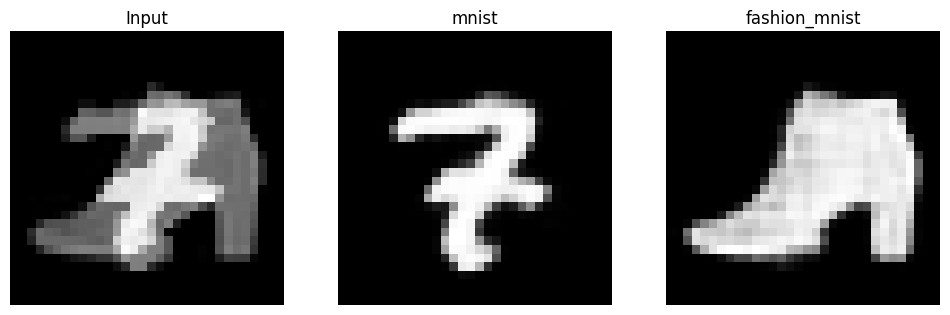



Campione di esempio numero  13


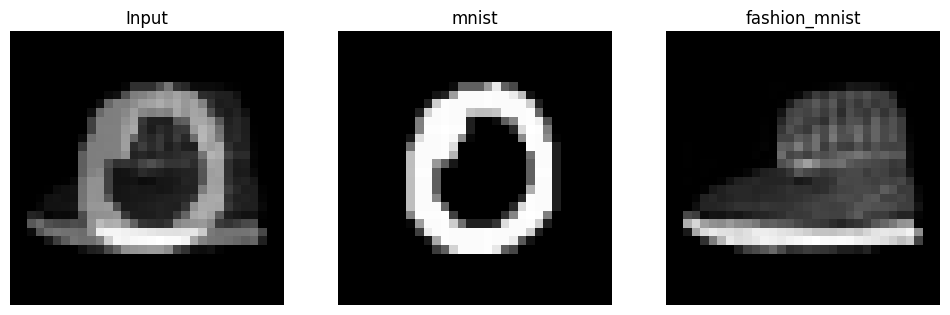

Previsione del modello banale


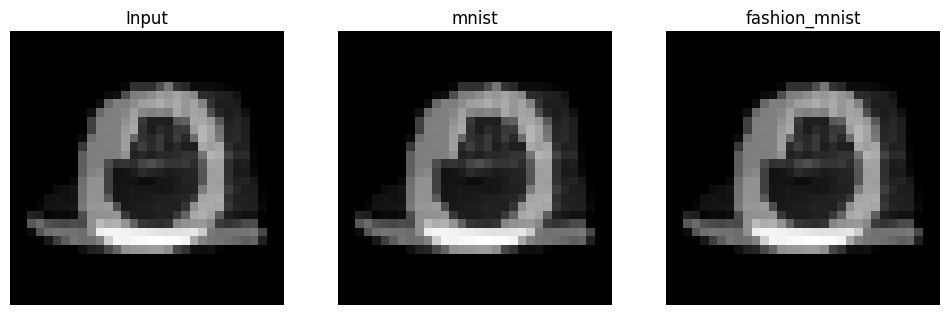

Previsione della rete neurale
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


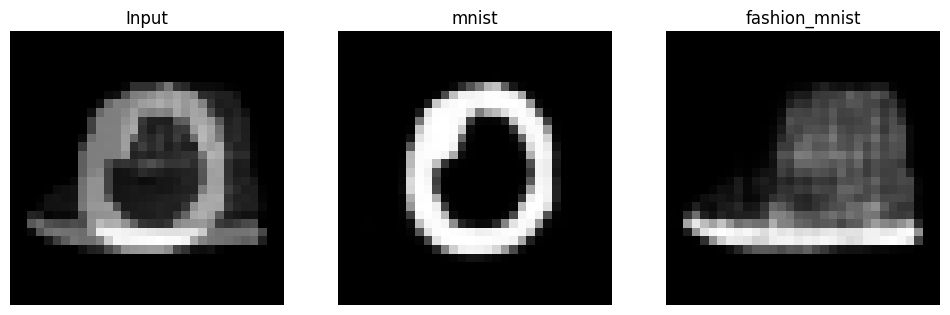



Campione di esempio numero  14


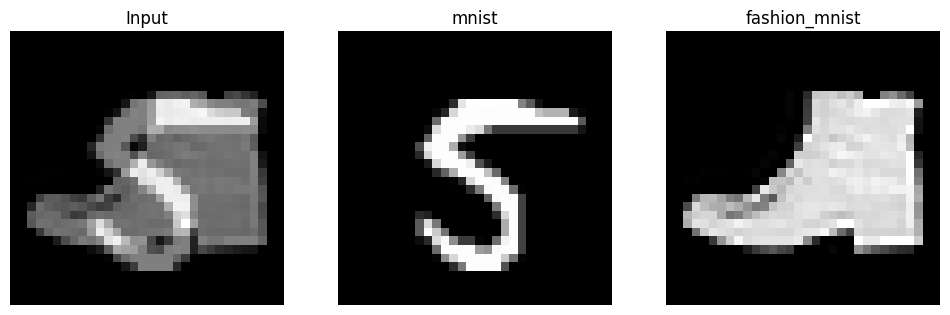

Previsione del modello banale


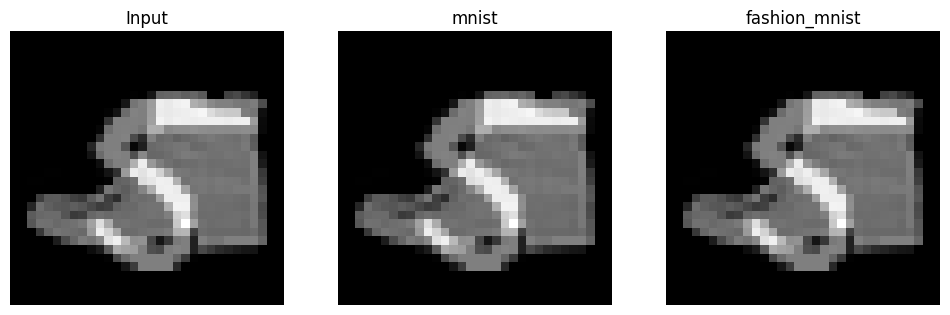

Previsione della rete neurale
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


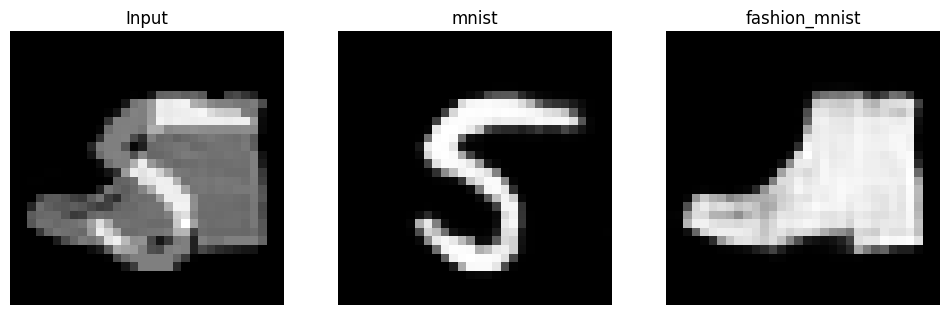



Campione di esempio numero  15


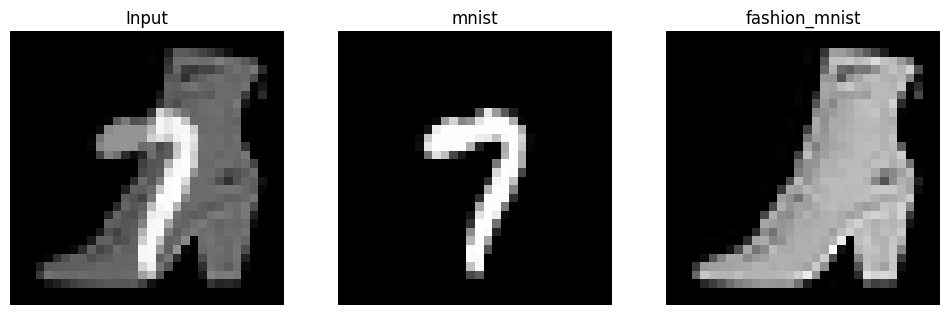

Previsione del modello banale


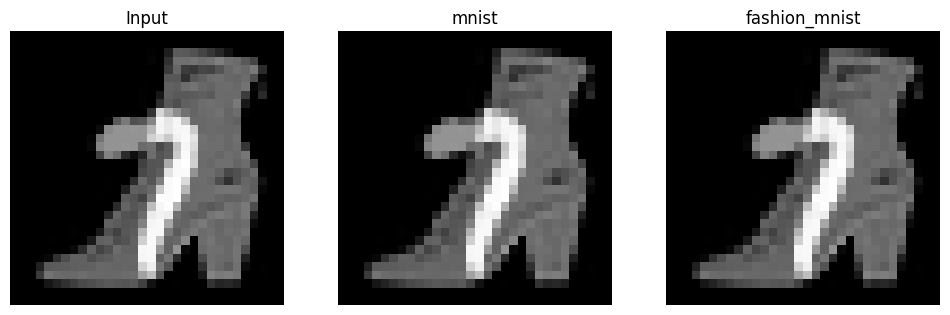

Previsione della rete neurale
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


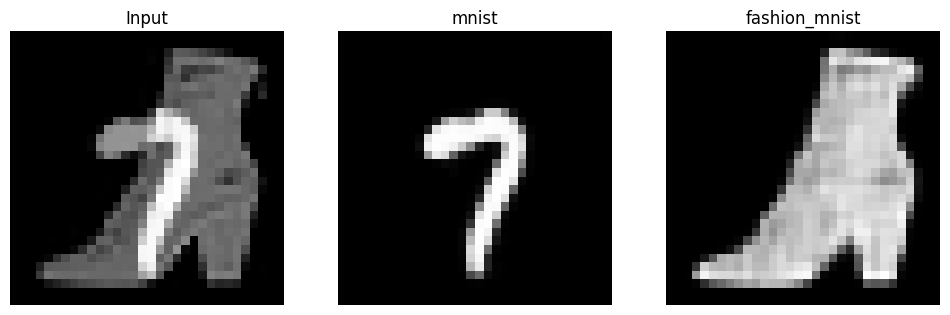



Campione di esempio numero  16


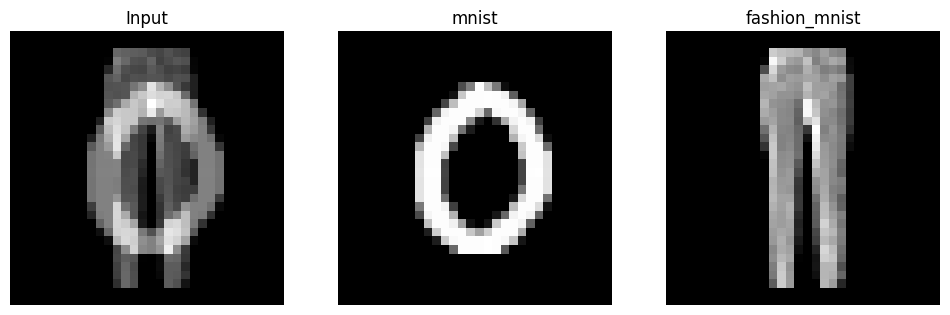

Previsione del modello banale


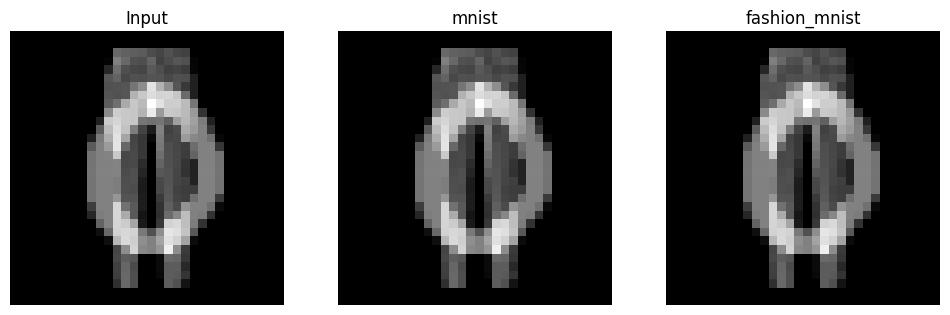

Previsione della rete neurale
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


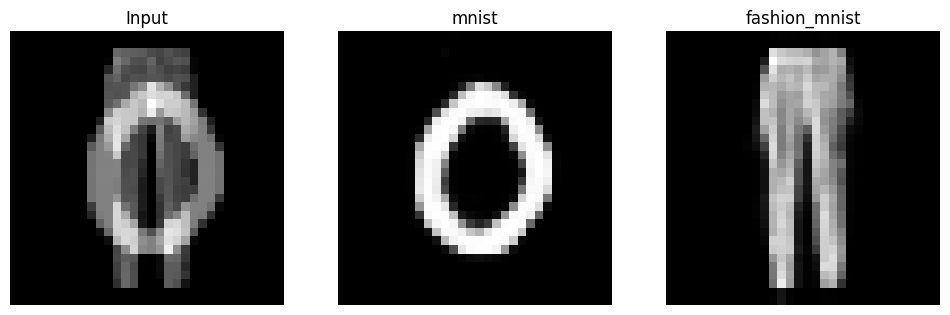



Campione di esempio numero  17


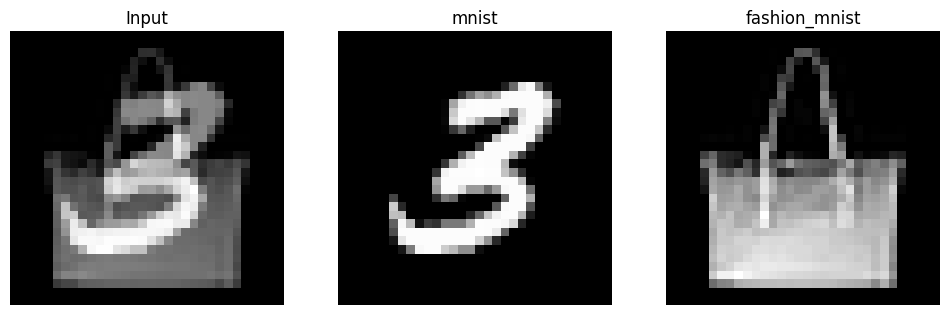

Previsione del modello banale


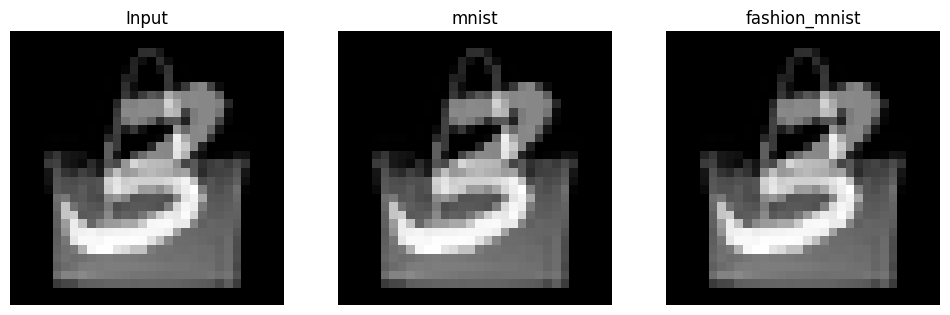

Previsione della rete neurale
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


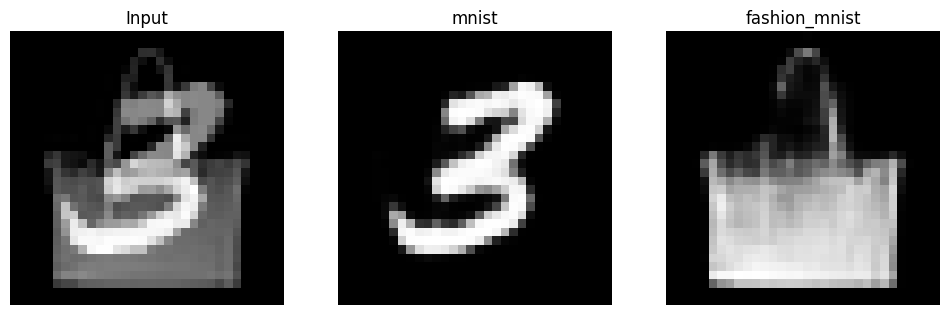



Campione di esempio numero  18


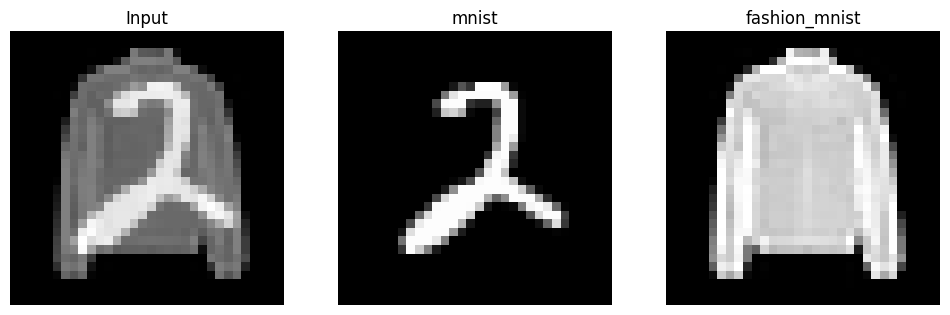

Previsione del modello banale


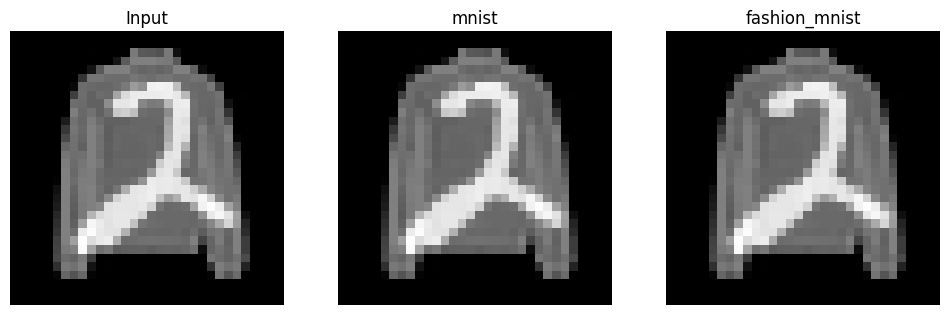

Previsione della rete neurale
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


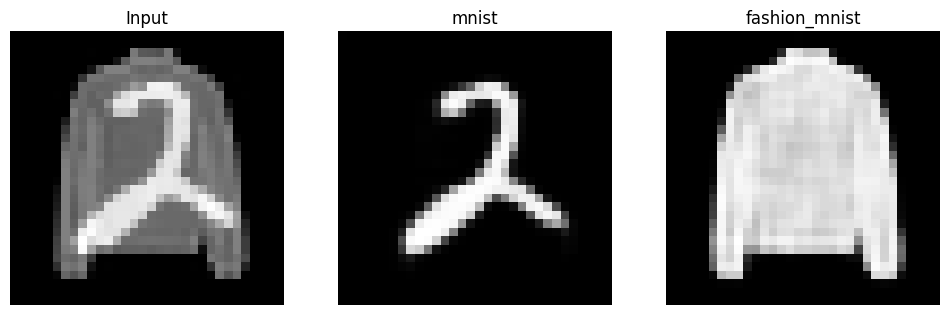



Campione di esempio numero  19


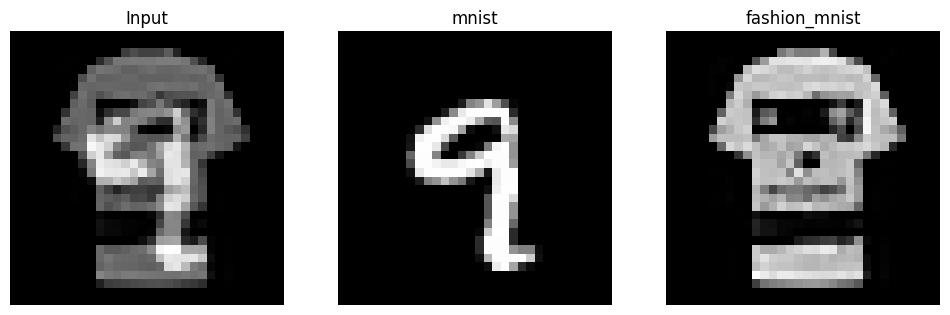

Previsione del modello banale


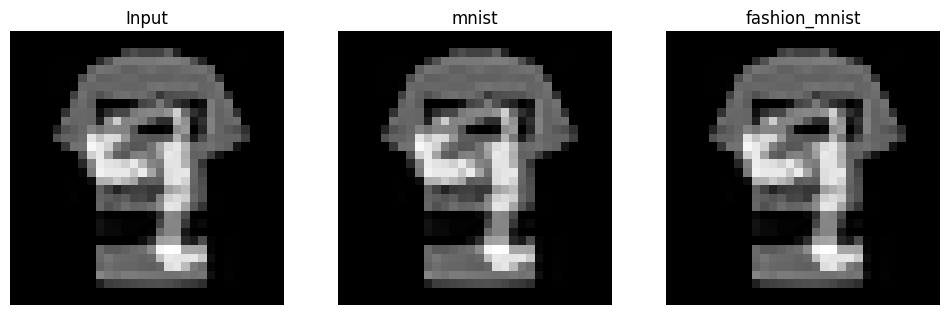

Previsione della rete neurale
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


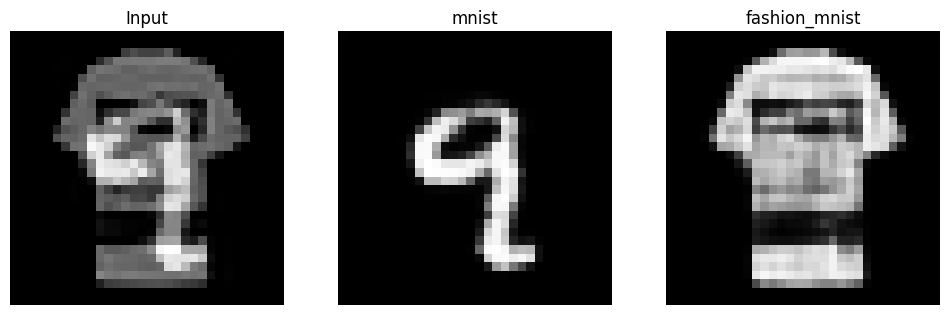



Campione di esempio numero  20


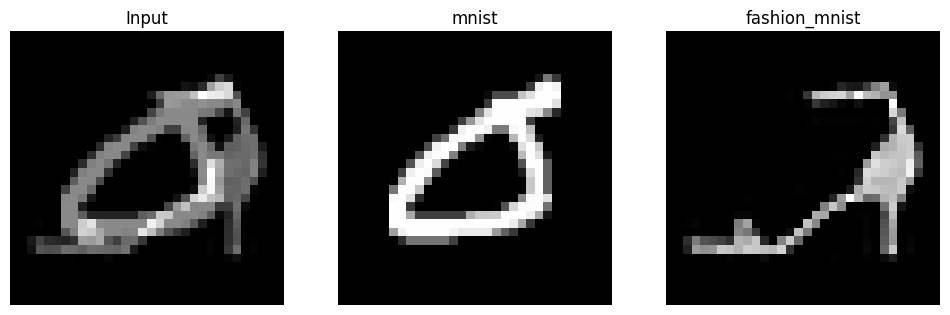

Previsione del modello banale


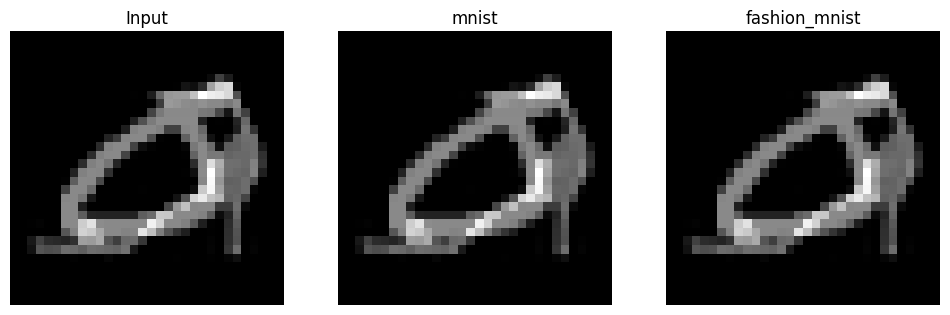

Previsione della rete neurale
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


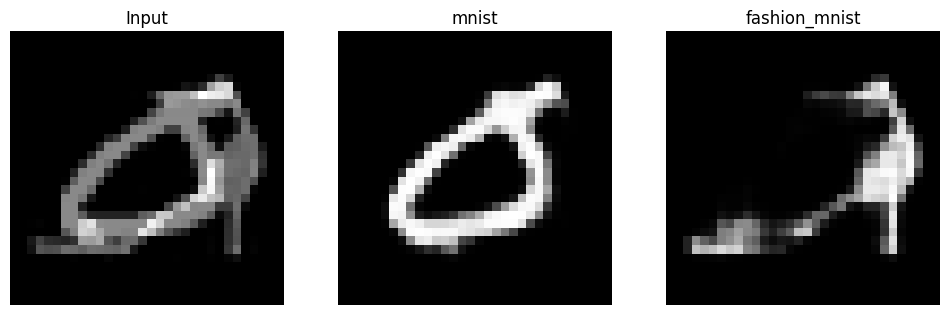



Campione di esempio numero  21


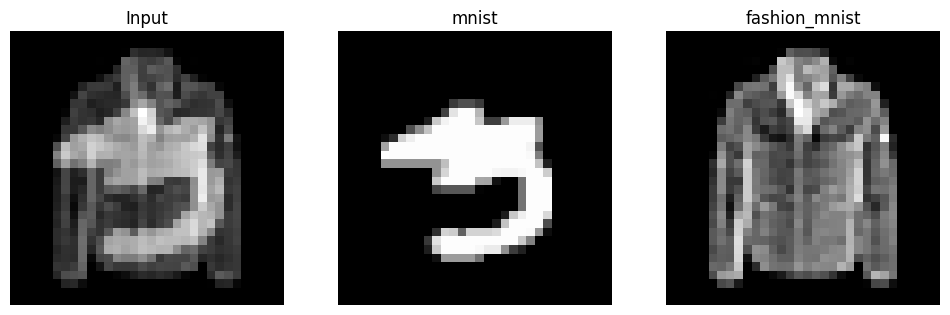

Previsione del modello banale


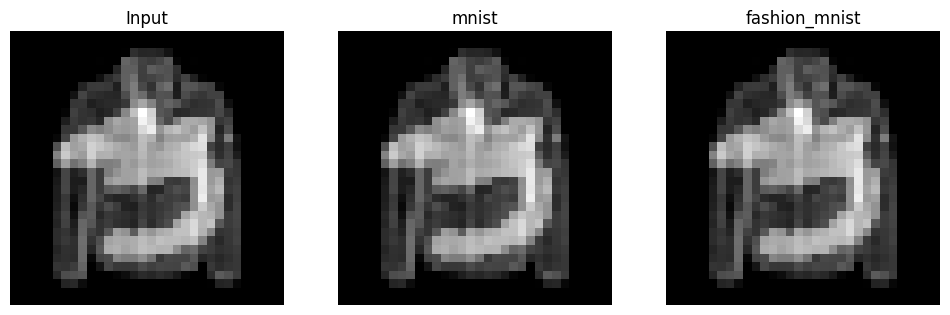

Previsione della rete neurale
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


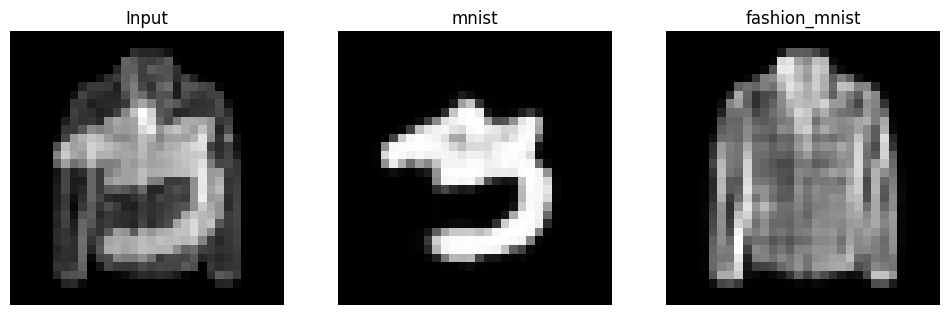



Campione di esempio numero  22


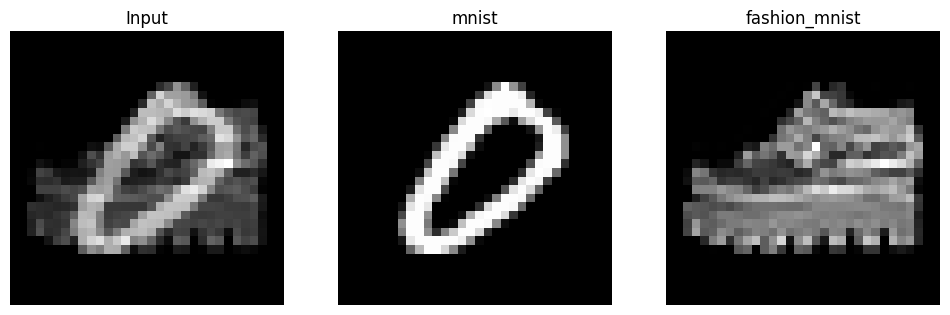

Previsione del modello banale


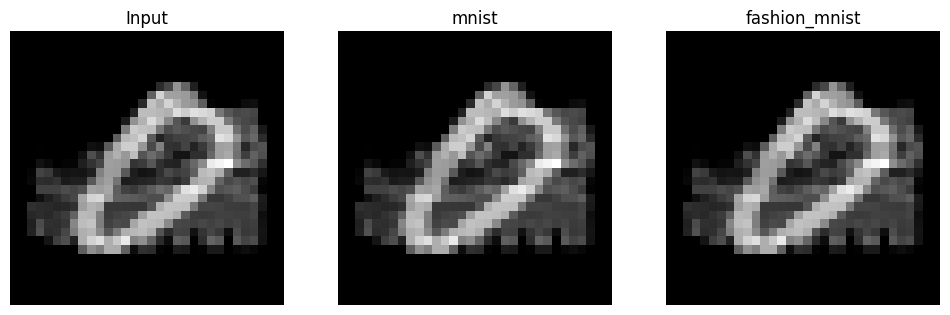

Previsione della rete neurale
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


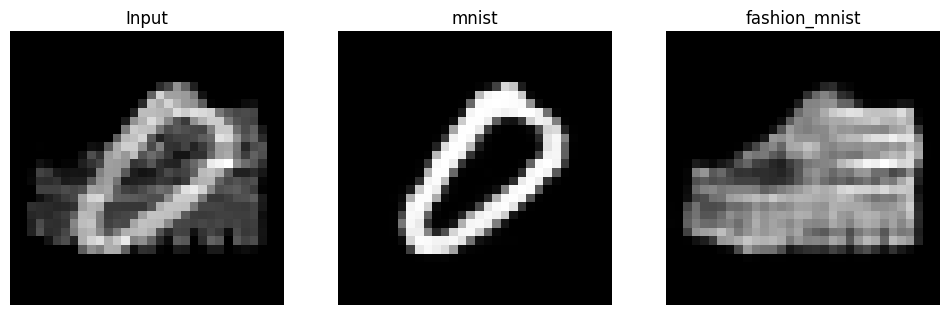



Campione di esempio numero  23


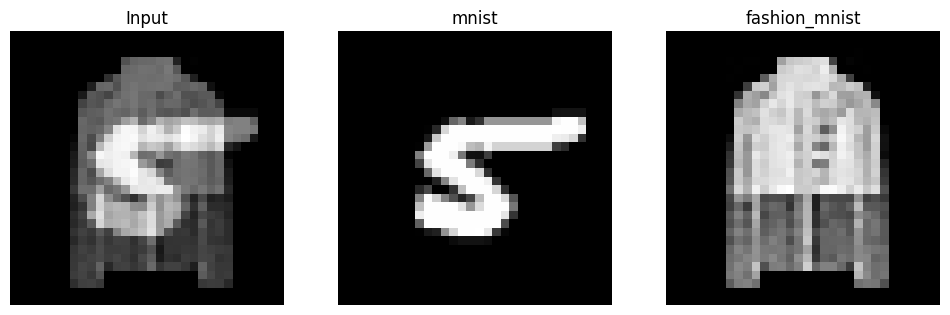

Previsione del modello banale


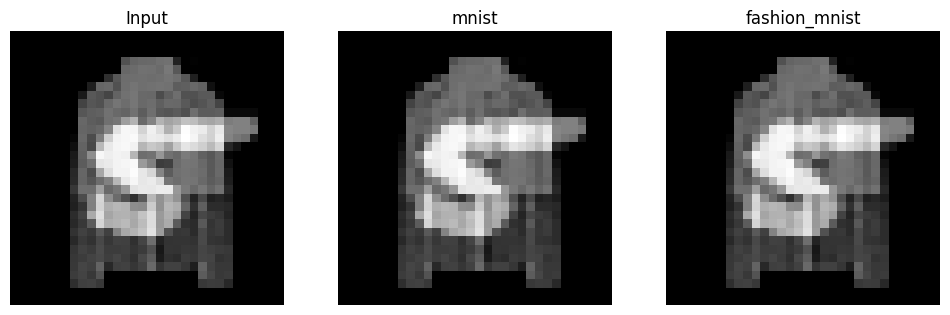

Previsione della rete neurale
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


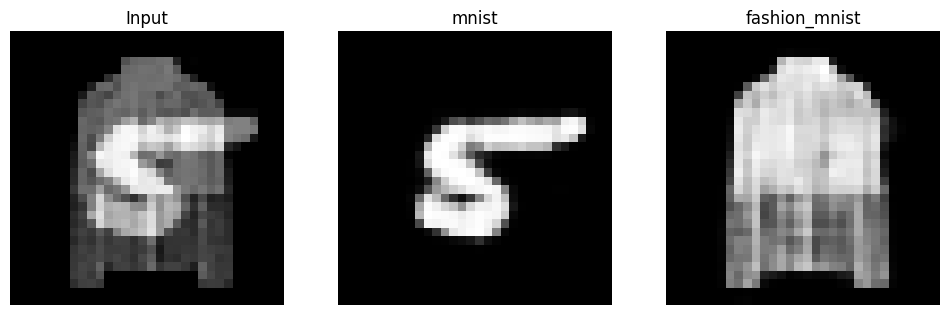



Campione di esempio numero  24


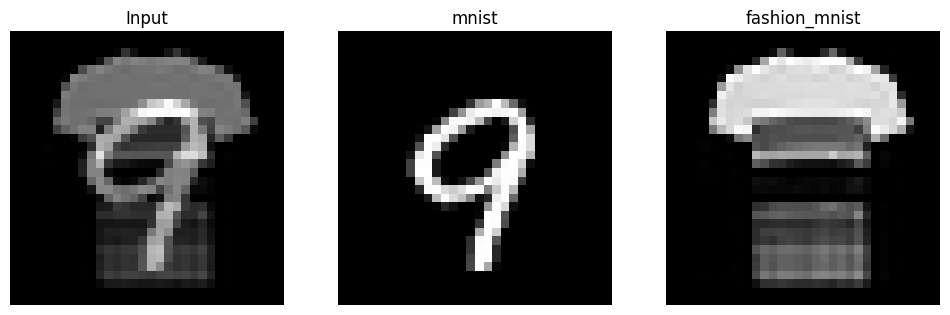

Previsione del modello banale


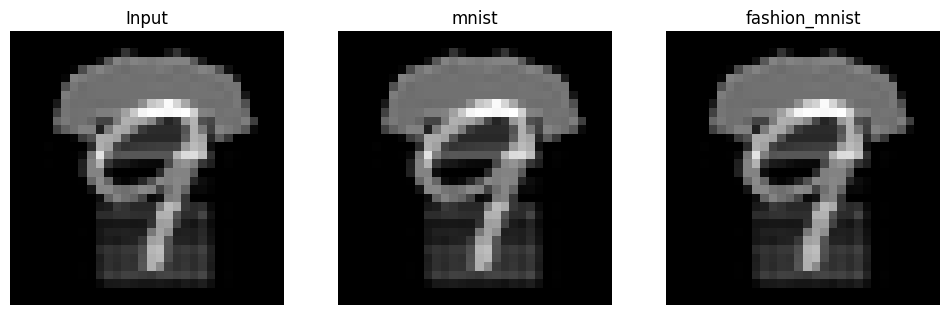

Previsione della rete neurale
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


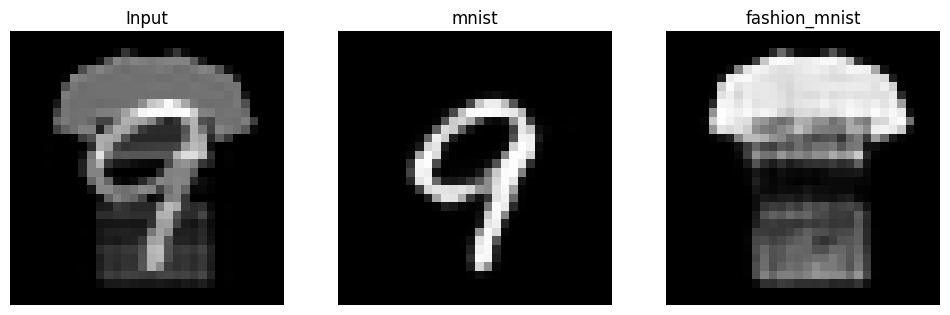



Campione di esempio numero  25


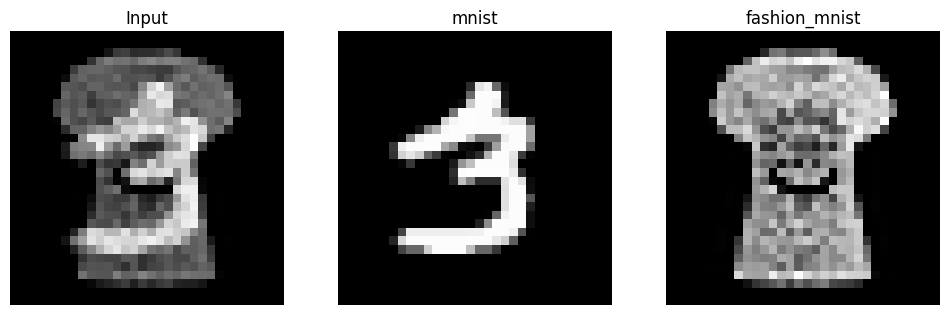

Previsione del modello banale


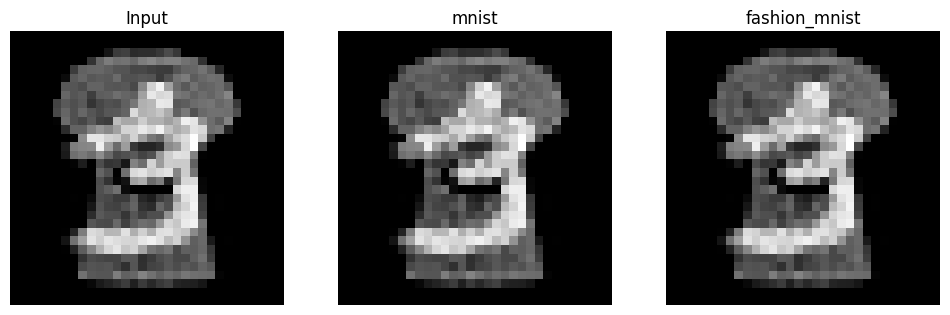

Previsione della rete neurale
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


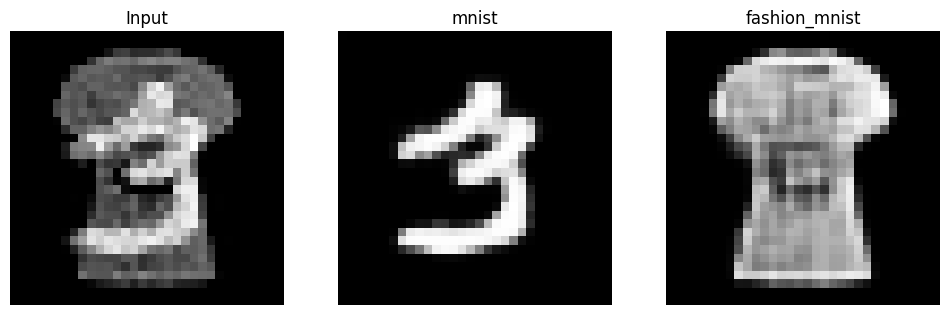



Campione di esempio numero  26


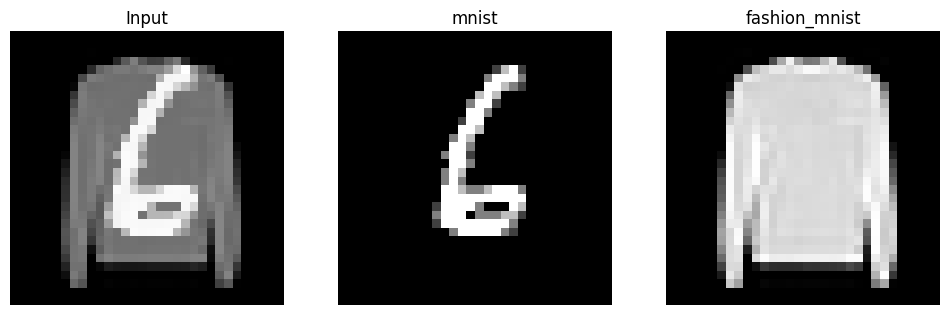

Previsione del modello banale


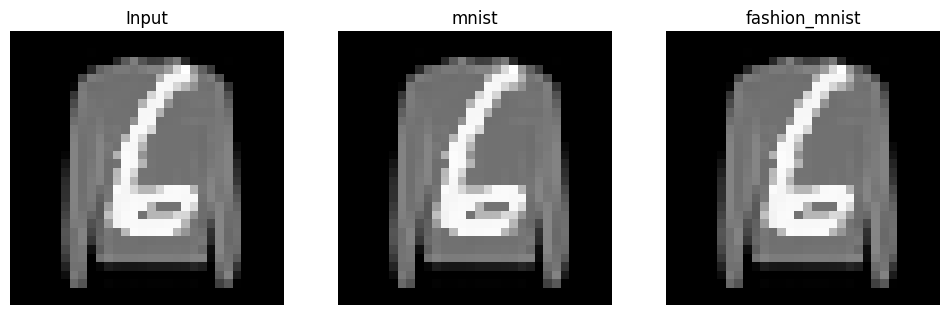

Previsione della rete neurale
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


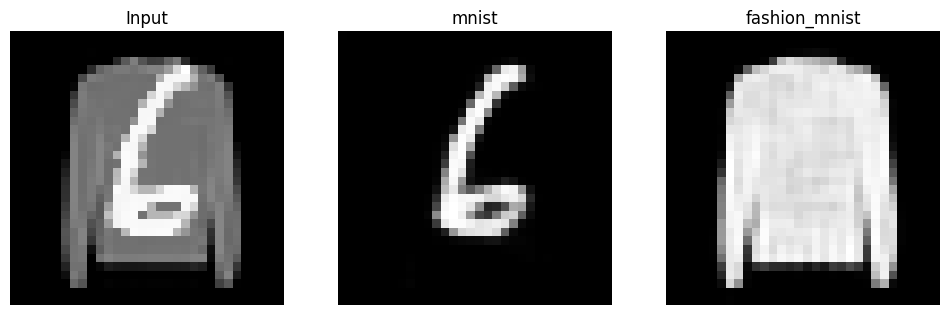



Campione di esempio numero  27


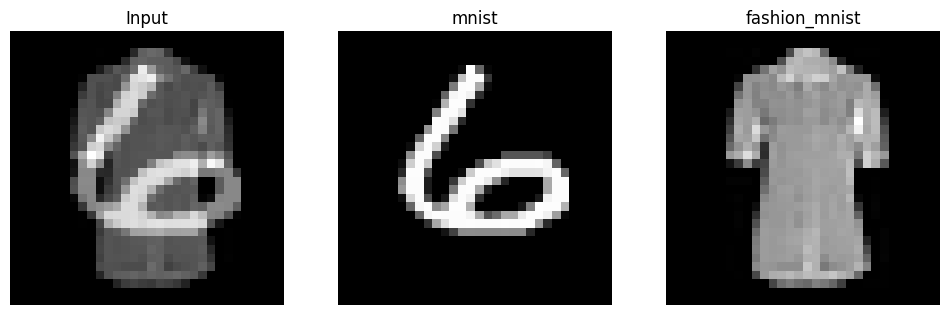

Previsione del modello banale


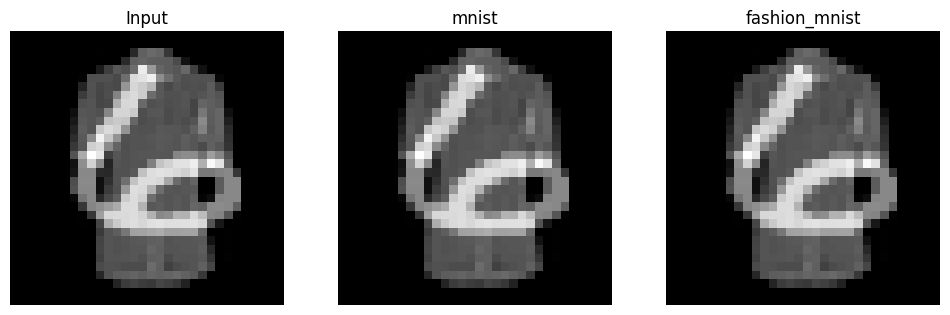

Previsione della rete neurale
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


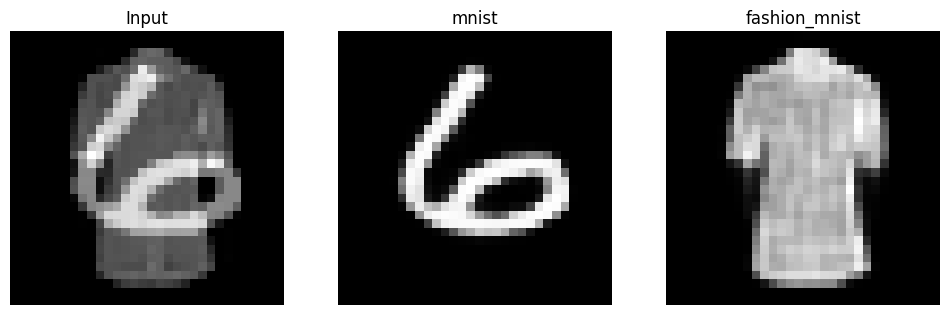



Campione di esempio numero  28


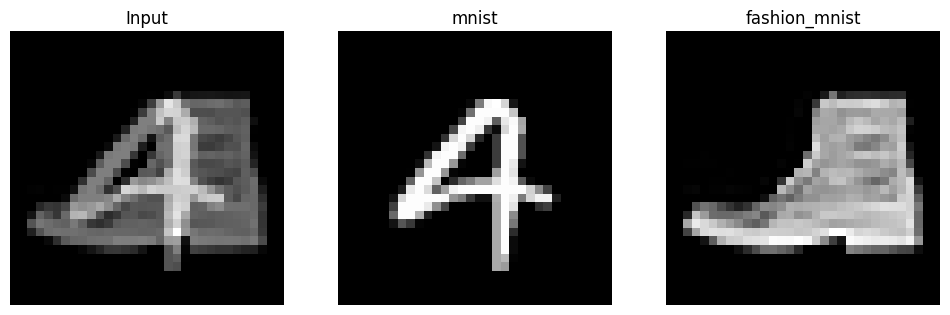

Previsione del modello banale


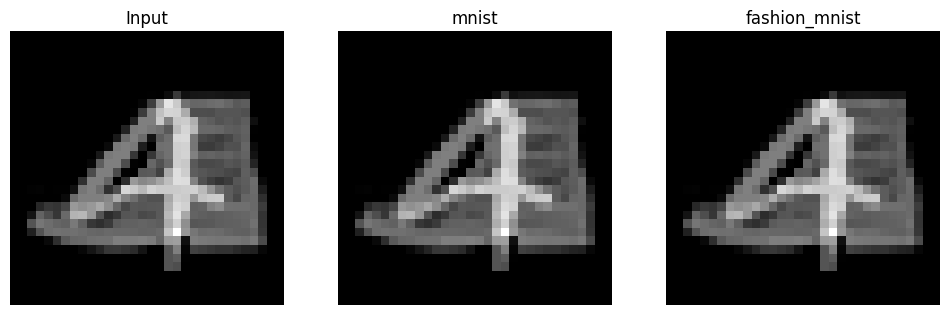

Previsione della rete neurale
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


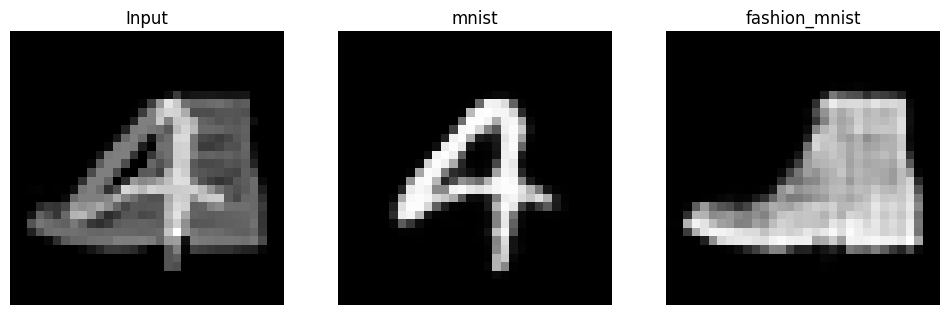



Campione di esempio numero  29


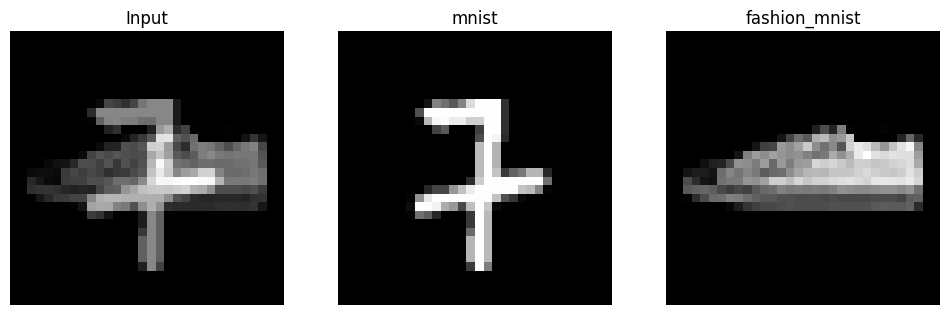

Previsione del modello banale


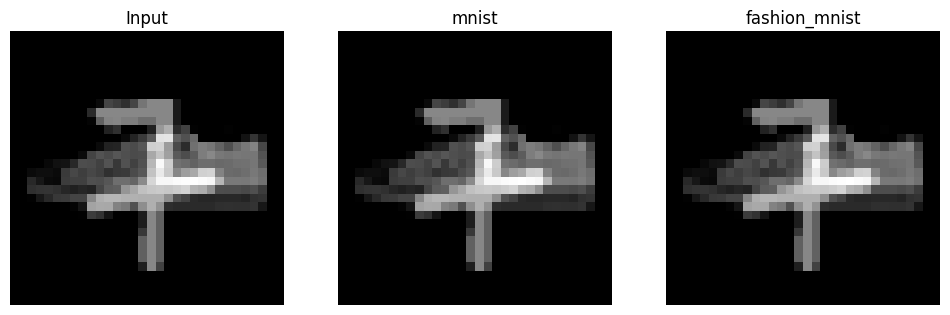

Previsione della rete neurale
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


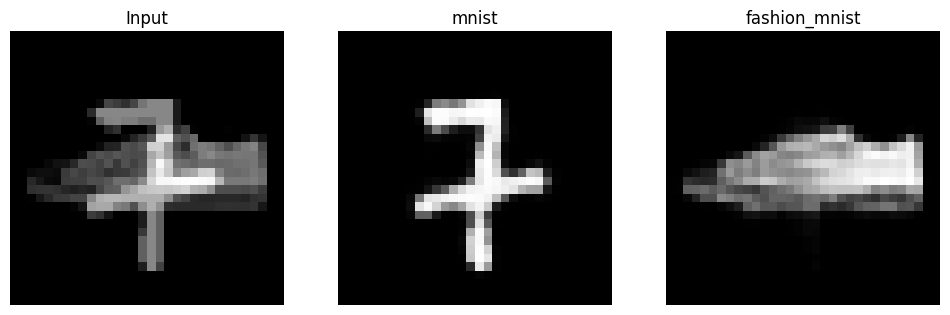

In [30]:
onegen = datagenerator(mnist_x_test, fashion_mnist_x_test, 1)

def show_images(x, y1, y2):
    fig, ax = plt.subplots(1, 3, figsize=(12,4))
    ax[0].imshow(x,cmap='gray')
    ax[0].title.set_text('Input')
    ax[0].axis('off')
    ax[1].imshow(y1,cmap='gray')
    ax[1].title.set_text('mnist')
    ax[1].axis('off')
    ax[2].imshow(y2,cmap='gray')
    ax[2].title.set_text('fashion_mnist')
    ax[2].axis('off')
    plt.show()

for i in range(1, 30):
  print('Campione di esempio numero ', i)
  x, (y1, y2) = next(onegen)
  show_images(x[0], y1[0], y2[0])

  print('Previsione del modello banale')
  y1_pred, y2_pred = ide_model(x)
  show_images(x[0], y1_pred[0], y2_pred[0])

  print('Previsione della rete neurale')
  y1_pred, y2_pred = model.predict(x)
  show_images(x[0], y1_pred[0], y2_pred[0])

  print()
  print()